In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Replace the path with the actual dataset path shown in Kaggle
df = pd.read_csv("/kaggle/input/floodprediction/FloodPrediction.csv")


2025-09-13 14:38:39.922115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757774320.252571      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757774320.342172      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

"""
flood_utils.py
Utility helpers for model evaluation, feature importance, and timing measurements.
Designed to be imported into an existing notebook without changing its structure much.

Functions:
- evaluate_cv(model, X, y, cv=5, n_jobs=1): return accuracy, precision, recall, f1, roc_auc (mean & std)
- fit_with_timing(model, X, y, **fit_kwargs): fit model and return timing information
- predict_with_timing(model, X, repeat=1): measure inference time and throughput
- feature_importance_rf(model, feature_names=None, top_n=20): for RandomForest-like models
- permutation_importance_any(model, X, y, n_repeats=10, scoring=None): permutation importance
- shap_explain(model, X, feature_names=None, nsamples=100): attempts SHAP; falls back to permutation importance
- measure_cv_costs(model, X, y, cv=5, n_jobs=1): cross-validation scoring with timing info

The functions are written to be robust and to fail gracefully with helpful messages.
"""

import time
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
import warnings
import time
import math
import sys

def _choose_roc_scoring(y):
    """Choose roc scoring key for cross_validate depending on binary/multiclass."""
    unique = np.unique(y)
    if unique.shape[0] == 2:
        return "roc_auc"
    else:
        # use one-vs-rest ROC AUC (requires probability or decision function)
        return "roc_auc_ovr"

def evaluate_cv(estimator, X, y, cv=5, n_jobs=1, random_state=None, return_raw=False):
    """
    Cross-validate the final model and return mean & std for accuracy, precision, recall, f1, roc_auc.
    - estimator: sklearn-like estimator (must implement fit/predict and preferably predict_proba)
    - X, y: arrays or DataFrame/Series
    - cv: integer or CV splitter
    - return_raw: if True, returns the raw cross_validate result dict in addition to summary
    Returns: dict with metrics -> (mean, std) and optionally the raw cv dict.
    """
    # create scoring dict
    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average='macro', zero_division=0),
        "recall": make_scorer(recall_score, average='macro', zero_division=0),
        "f1": make_scorer(f1_score, average='macro', zero_division=0),
    }
    try:
        scoring[_choose_roc_scoring(y)] = _roc_scorer_factory(y)
    except Exception:
        # fallback: try to add roc_auc if possible
        try:
            scoring["roc_auc"] = "roc_auc"
        except Exception:
            warnings.warn("ROC AUC scoring will be skipped.")
    # run cross_validate
    if isinstance(cv, int):
        cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    else:
        cv_split = cv
    cv_res = cross_validate(estimator, X, y, scoring=scoring, cv=cv_split, return_train_score=False, n_jobs=n_jobs, error_score=np.nan)
    # aggregate results
    summary = {}
    for k, v in cv_res.items():
        # we only care about test_ scores
        if k.startswith("test_"):
            name = k[len("test_"):]
            arr = np.array(v, dtype=float)
            # ignore nan folds if estimator failed on some split
            arr = arr[~np.isnan(arr)]
            if arr.size == 0:
                mean = float("nan"); std = float("nan")
            else:
                mean = float(np.mean(arr)); std = float(np.std(arr, ddof=1)) if arr.size>1 else 0.0
            summary[name] = {"mean": mean, "std": std, "values": arr.tolist()}
    if return_raw:
        return summary, cv_res
    return summary

def _roc_scorer_factory(y):
    """Return a roc scorer string (for cross_validate) chosen for the task."""
    unique = np.unique(y)
    if unique.shape[0] == 2:
        return "roc_auc"
    else:
        # multiclass: ovR roc auc if estimator supports predict_proba
        return "roc_auc_ovr"

def fit_with_timing(estimator, X, y, verbose=False, **fit_kwargs):
    """
    Fit estimator and return a tuple (estimator, timings_dict).
    timings_dict contains wall_time (seconds) and cpu_time (seconds).
    Additional values in fit_kwargs are passed to estimator.fit.
    """
    t0_wall = time.perf_counter()
    t0_cpu = time.process_time()
    estimator.fit(X, y, **fit_kwargs)
    t1_wall = time.perf_counter()
    t1_cpu = time.process_time()
    timings = {
        "fit_wall_time_s": t1_wall - t0_wall,
        "fit_cpu_time_s": t1_cpu - t0_cpu
    }
    if verbose:
        print(f"Fit wall time: {timings['fit_wall_time_s']:.4f}s, CPU time: {timings['fit_cpu_time_s']:.4f}s")
    return estimator, timings

def predict_with_timing(estimator, X, repeat=1, method="predict", verbose=False):
    """
    Measure inference timing.
    - repeat: number of times to run inference to get more stable timing (default 1)
    - method: "predict" or "predict_proba" or "decision_function" - will choose the available one.
    Returns: dict with total_time_s, avg_time_per_run_s, time_per_sample_s, throughput_samples_per_s, method_used.
    """
    if method not in ("predict", "predict_proba", "decision_function"):
        raise ValueError("method must be one of 'predict', 'predict_proba', 'decision_function'")
    # choose available method
    if method == "predict_proba" and not hasattr(estimator, "predict_proba"):
        if hasattr(estimator, "decision_function"):
            method = "decision_function"
        else:
            method = "predict"
    if method == "decision_function" and not hasattr(estimator, "decision_function"):
        if hasattr(estimator, "predict_proba"):
            method = "predict_proba"
        else:
            method = "predict"
    func = getattr(estimator, method)
    n_samples = X.shape[0] if hasattr(X, "shape") else len(X)
    # run once as warm-up
    try:
        _ = func(X)
    except Exception as e:
        # attempt to call with batch-wise iteration if large inputs break something
        raise RuntimeError(f"Failed a warm-up call to estimator.{method}(): {e}")
    t0 = time.perf_counter()
    for _ in range(repeat):
        _ = func(X)
    t1 = time.perf_counter()
    total = t1 - t0
    avg_run = total / repeat
    per_sample = avg_run / max(1, n_samples)
    throughput = (n_samples / avg_run) if avg_run>0 else float("inf")
    result = {
        "method_used": method,
        "total_time_s": total,
        "avg_time_per_run_s": avg_run,
        "time_per_sample_s": per_sample,
        "throughput_samples_per_s": throughput,
        "n_samples": n_samples,
        "repeat": repeat
    }
    if verbose:
        print(f"Inference: {result['avg_time_per_run_s']:.4f}s per run, {result['time_per_sample_s']*1e3:.4f}ms per sample, {result['throughput_samples_per_s']:.2f} samples/s")
    return result

def feature_importance_rf(model, feature_names=None, top_n=20):
    """
    Extract feature importances from tree-based models like RandomForest.
    Returns a pandas DataFrame sorted by importance descending.
    """
    if not hasattr(model, "feature_importances_"):
        raise AttributeError("Model has no attribute 'feature_importances_'. Use permutation_importance_any() or shap_explain().")
    importances = np.array(model.feature_importances_, dtype=float)
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(len(importances))]
    if len(feature_names) != len(importances):
        raise ValueError("feature_names length does not match number of importances.")
    df = pd.DataFrame({"feature": feature_names, "importance": importances})
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)
    return df.head(top_n)

def permutation_importance_any(model, X, y, n_repeats=10, scoring=None, random_state=None, n_jobs=None):
    """
    Wrapper for sklearn.inspection.permutation_importance to work for any estimator.
    Returns pandas DataFrame with mean importance and std.
    """
    if scoring is None:
        # choose accuracy by default
        scoring = "accuracy"
    res = permutation_importance(model, X, y, n_repeats=n_repeats, scoring=scoring, random_state=random_state, n_jobs=n_jobs)
    means = res.importances_mean
    stds = res.importances_std
    names = None
    if hasattr(X, "columns"):
        names = list(X.columns)
    else:
        names = [f"f{i}" for i in range(len(means))]
    df = pd.DataFrame({"feature": names, "importance_mean": means, "importance_std": stds})
    df = df.sort_values("importance_mean", ascending=False).reset_index(drop=True)
    return df

def shap_explain(model, X, feature_names=None, nsamples=100):
    """
    Try to produce SHAP values. If 'shap' is not installed or explainer cannot be used,
    falls back to permutation importance.
    Returns a dict with keys: 'method' ('shap' or 'permutation'), and 'result' (DataFrame or array)
    """
    try:
        import shap
    except Exception as e:
        warnings.warn("shap not available (pip install shap). Falling back to permutation importance.")
        # fallback
        return {"method": "permutation", "result": permutation_importance_any(model, X, X if False else _y_placeholder(X), n_repeats=10)}
    # Choose explainer automatically
    try:
        # For tree models, TreeExplainer is fastest/most accurate
        if hasattr(model, "predict_proba") and hasattr(model, "feature_importances_"):
            explainer = shap.TreeExplainer(model)
        else:
            # use a model-agnostic explainer
            explainer = shap.Explainer(model, X)  # shap will select a good default
        # compute shap values on a sample (to keep runtime small)
        sample = X if (hasattr(X, "shape") and X.shape[0] <= nsamples) else (X.iloc[:nsamples] if hasattr(X, "iloc") else X[:nsamples])
        shap_values = explainer(sample)
        # shap_values can be an Explanation object; convert to mean absolute importance
        if hasattr(shap_values, "values"):
            vals = shap_values.values
            # if multiclass shap_values.values may be list/array shape (classes, nsamples, nfeatures)
            if isinstance(vals, list) or (hasattr(vals, "ndim") and vals.ndim == 3):
                # take mean over classes then mean abs over samples
                arr = np.mean(np.abs(vals), axis=0) if isinstance(vals, list) else np.mean(np.abs(vals), axis=0)
                mean_abs = np.mean(arr, axis=0)
            else:
                mean_abs = np.mean(np.abs(vals), axis=0)
        else:
            # fallback: try shap_values.data
            mean_abs = np.mean(np.abs(shap_values), axis=0)
        if feature_names is None:
            if hasattr(X, "columns"):
                feature_names = list(X.columns)
            else:
                feature_names = [f"f{i}" for i in range(len(mean_abs))]
        df = pd.DataFrame({"feature": feature_names, "shap_mean_abs": mean_abs})
        df = df.sort_values("shap_mean_abs", ascending=False).reset_index(drop=True)
        return {"method": "shap", "result": df}
    except Exception as e:
        warnings.warn(f"SHAP explanation failed: {e}. Falling back to permutation importance.")
        return {"method": "permutation", "result": permutation_importance_any(model, X, _y_placeholder(X), n_repeats=10)}

def _y_placeholder(X):
    """Helper: placeholder for functions that require y but we don't have it in shap fallback. 
    Raises an informative error so the caller provides y instead of relying on shap fallback."""
    raise RuntimeError("Permutation fallback requires true labels 'y'. Call permutation_importance_any(model, X, y, ...) directly.")

def measure_cv_costs(estimator, X, y, cv=5, n_jobs=1, random_state=None):
    """
    Cross-validate and report timing metrics: mean fit_time, mean score_time and the usual metrics.
    Returns: dict containing 'cv_summary' (metrics) and 'timings' (from cross_validate: fit_time, score_time arrays).
    """
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision_macro",
        "recall": "recall_macro",
        "f1": "f1_macro",
    }
    try:
        scoring[_choose_roc_scoring(y)] = _roc_scorer_factory(y)
    except Exception:
        pass
    if isinstance(cv, int):
        cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    else:
        cv_split = cv
    cv_res = cross_validate(estimator, X, y, scoring=scoring, cv=cv_split, return_train_score=False, n_jobs=n_jobs, error_score=np.nan)
    timings = {
        "fit_time_s_per_fold": cv_res.get("fit_time", []),
        "score_time_s_per_fold": cv_res.get("score_time", [])
    }
    metrics = {}
    for k, v in cv_res.items():
        if k.startswith("test_"):
            name = k[len("test_"):]
            arr = np.array(v, dtype=float)
            arr = arr[~np.isnan(arr)]
            metrics[name] = {"mean": float(np.mean(arr)) if arr.size>0 else float("nan"), "std": float(np.std(arr, ddof=1)) if arr.size>1 else 0.0}
    return {"cv_summary": metrics, "timings": timings, "raw_cv_result": cv_res}


In [3]:
# paste this into your notebook
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings

def _make_scorer(metric):
    metric = metric.lower()
    if metric == "accuracy": return "accuracy"
    if metric == "precision": return "precision_macro"
    if metric == "recall": return "recall_macro"
    if metric == "f1": return "f1_macro"
    if metric in ("roc_auc","auc"): return "roc_auc"
    raise ValueError("metric must be one of: accuracy, precision, recall, f1, roc_auc")

def _cv_split(cv, X, y, random_state=None):
    if isinstance(cv, int):
        # use stratified for classification-like labels
        unique = np.unique(y)
        if unique.shape[0] == 2 or unique.shape[0] < 20:
            return StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        else:
            return KFold(n_splits=cv, shuffle=True, random_state=random_state)
    return cv

def paired_model_tests(est1, est2, X, y, cv=5, metric="accuracy",
                       n_permutations=2000, n_bootstrap=2000, random_state=None):
    """
    Compare two estimators using CV.
    Returns dict with per-fold scores, mean diff, t-test, wilcoxon (if scipy), permutation p, bootstrap CI, cohens_d.
    - est1, est2: estimators (will be cloned inside)
    - X, y: data (pandas DataFrame/Series or numpy arrays)
    - cv: int or CV splitter
    - metric: 'accuracy','precision','recall','f1','roc_auc'
    """
    from sklearn.base import clone
    from sklearn.model_selection import cross_validate

    scoring = _make_scorer(metric)
    cv_split = _cv_split(cv, X, y, random_state=random_state)

    # We'll run cross_validate fold-by-fold to keep paired folds identical and to fit fresh clones
    scores1 = []
    scores2 = []
    for train_idx, test_idx in cv_split.split(X, y):
        X_tr = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_te = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_tr = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_te = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_te = scaler.transform(X_te)

        e1 = clone(est1); e2 = clone(est2)
        e1.fit(X_tr, y_tr); e2.fit(X_tr, y_tr)

        # For roc_auc we need probability/decision scores; use metric scoring via manual eval
        if scoring == "roc_auc":
            # try predict_proba / decision_function for each model
            def _score_auc(m):
                if hasattr(m, "predict_proba"):
                    p = m.predict_proba(X_te)
                    if p.ndim>1 and p.shape[1]>1:
                        return roc_auc_score(y_te, p[:,1])
                    else:
                        return roc_auc_score(y_te, p)
                if hasattr(m, "decision_function"):
                    return roc_auc_score(y_te, m.decision_function(X_te))
                # fallback: use predicted labels (not ideal)
                return roc_auc_score(y_te, m.predict(X_te))
            s1 = _score_auc(e1)
            s2 = _score_auc(e2)
        else:
            # classification metrics using predictions
            y1p = e1.predict(X_te); y2p = e2.predict(X_te)
            if scoring == "accuracy":
                s1 = accuracy_score(y_te, y1p); s2 = accuracy_score(y_te, y2p)
            elif scoring == "precision_macro":
                s1 = precision_score(y_te, y1p, average="macro", zero_division=0)
                s2 = precision_score(y_te, y2p, average="macro", zero_division=0)
            elif scoring == "recall_macro":
                s1 = recall_score(y_te, y1p, average="macro", zero_division=0)
                s2 = recall_score(y_te, y2p, average="macro", zero_division=0)
            elif scoring == "f1_macro":
                s1 = f1_score(y_te, y1p, average="macro", zero_division=0)
                s2 = f1_score(y_te, y2p, average="macro", zero_division=0)
            else:
                raise ValueError("Unhandled scoring: " + str(scoring))

        scores1.append(float(s1)); scores2.append(float(s2))

    scores1 = np.asarray(scores1); scores2 = np.asarray(scores2)
    diffs = scores1 - scores2
    mean_diff = float(diffs.mean())
    std_diff = float(diffs.std(ddof=1)) if len(diffs)>1 else 0.0

    # Cohen's d (paired)
    cohens_d = None
    if len(diffs) > 1:
        denom = np.std(diffs, ddof=1) if np.std(diffs, ddof=1) > 0 else 1e-12
        cohens_d = mean_diff / denom

    # t-test and Wilcoxon if scipy available
    ttest = None; wilcoxon_p = None
    try:
        from scipy import stats
        if len(diffs) > 1:
            t_stat, t_p = stats.ttest_rel(scores1, scores2, nan_policy="omit")
            ttest = {"statistic": float(t_stat), "pvalue": float(t_p)}
            try:
                w_stat, w_p = stats.wilcoxon(scores1, scores2)
                wilcoxon_p = float(w_p)
            except Exception:
                wilcoxon_p = None
    except Exception:
        ttest = None; wilcoxon_p = None

    # Paired permutation test (non-parametric)
    perm_p = None
    try:
        rng = np.random.RandomState(random_state)
        obs = abs(mean_diff)
        n = len(diffs)
        count = 0
        for i in range(n_permutations):
            signs = rng.choice([-1, 1], size=n)
            stat = abs(np.mean(diffs * signs))
            if stat >= obs - 1e-15:
                count += 1
        perm_p = (count + 1) / (n_permutations + 1)
    except Exception as e:
        perm_p = None; warnings.warn(f"Permutation test failed: {e}")

    # Bootstrap CI for mean difference
    ci = (None, None)
    try:
        rng = np.random.RandomState(random_state)
        boot = []
        n = len(diffs)
        for i in range(n_bootstrap):
            idx = rng.randint(0, n, size=n)
            boot.append(np.mean(diffs[idx]))
        lo = np.percentile(boot, 2.5)
        hi = np.percentile(boot, 97.5)
        ci = (float(lo), float(hi))
    except Exception as e:
        warnings.warn(f"Bootstrap CI failed: {e}")

    return {
        "scores1": scores1,
        "scores2": scores2,
        "diffs": diffs,
        "mean_diff": mean_diff,
        "std_diff": std_diff,
        "cohens_d": cohens_d,
        "t_test": ttest,
        "wilcoxon_p": wilcoxon_p,
        "permutation_pvalue": perm_p,
        "bootstrap_ci_95": ci,
        "n_folds": len(diffs)
    }

# McNemar test for paired classification predictions on the same test set
def mcnemar_test(y_true, y_pred1, y_pred2, exact=False):
    """
    McNemar test for two classifiers on the same samples.
    Returns dictionary {b, c, statistic, pvalue}, where
    b = # model1 correct & model2 wrong
    c = # model1 wrong & model2 correct
    """
    import numpy as np
    y_true = np.asarray(y_true)
    p1 = np.asarray(y_pred1); p2 = np.asarray(y_pred2)
    if not (len(y_true) == len(p1) == len(p2)):
        raise ValueError("All inputs must be same length")
    correct1 = (p1 == y_true)
    correct2 = (p2 == y_true)
    b = int(np.sum(np.logical_and(correct1, ~correct2)))
    c = int(np.sum(np.logical_and(~correct1, correct2)))
    stat = None; pvalue = None
    try:
        from scipy import stats
        if exact:
            # exact binomial test
            try:
                pvalue = float(stats.binom_test(x=b, n=b+c, p=0.5, alternative='two-sided')) if (b+c)>0 else 1.0
            except Exception:
                pvalue = float(stats.binomtest(k=b, n=b+c, p=0.5).pvalue) if (b+c)>0 else 1.0
            stat = None
        else:
            if (b+c) == 0:
                stat = 0.0; pvalue = 1.0
            else:
                stat = float((abs(b - c) - 1)**2 / (b + c))
                pvalue = float(stats.chi2.sf(stat, df=1))
    except Exception:
        # fallback normal approx
        if (b+c) == 0:
            stat=0.0; pvalue=1.0
        else:
            stat = float((b - c) / np.sqrt(b + c))
            try:
                from math import erf, sqrt
                pvalue = 2.0 * (1.0 - 0.5*(1.0 + erf(abs(stat)/np.sqrt(2))))
            except Exception:
                pvalue = None
    return {"b": b, "c": c, "statistic": stat, "pvalue": pvalue}


In [4]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

def evaluate_cv_keras(build_fn, X, y, cv=5, epochs=10, batch_size=32, verbose=0, random_state=0):
    """
    Cross-validate a Keras model builder over Stratified folds.
    - build_fn: callable that returns a fresh, *compiled* Keras model when called (no args).
                If your builder needs args, pass a lambda: lambda: try_model(8,60)
    - X, y: pandas objects or numpy arrays
    - cv: number of folds
    - epochs: epochs per fold
    - batch_size: ignored; training is done in full-batch (batch size == size of training fold)
                  (kept as a parameter just for API compatibility)
    - threshold for binary classification is set to 0.3 (as requested)
    Returns a dict with summarized metrics (mean/std/values).
    """
    # convert to numpy
    Xn = X.values if hasattr(X, "values") else np.asarray(X)
    yn = y.values if hasattr(y, "values") else np.asarray(y)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    accs, precs, recs, f1s, aucs = [], [], [], [], []

    THRESH = 0.3   # user-requested threshold

    for train_idx, test_idx in skf.split(Xn, yn):
        X_tr, X_te = Xn[train_idx], Xn[test_idx]
        y_tr, y_te = yn[train_idx], yn[test_idx]

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_te = scaler.transform(X_te)
        
        # clear old session BEFORE building a new model (safer)
        tf.keras.backend.clear_session()
        model = build_fn()   # build_fn must return a compiled model

        # full-batch training: use the full training fold as the batch
        full_batch_size = X_tr.shape[0]

        model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False)

        y_pred = model.predict(X_te)
        # handle outputs: multiclass vs binary proba
        if y_pred.ndim > 1 and y_pred.shape[1] > 1:  # multiclass softmax
            y_prob = y_pred
            y_hat = np.argmax(y_pred, axis=1)
        else:
            y_prob = y_pred.ravel()
            # **use threshold 0.3** as requested
            y_hat = (y_prob >= THRESH).astype(int)

        accs.append(accuracy_score(y_te, y_hat))
        precs.append(precision_score(y_te, y_hat, average='macro', zero_division=0))
        recs.append(recall_score(y_te, y_hat, average='macro', zero_division=0))
        f1s.append(f1_score(y_te, y_hat, average='macro', zero_division=0))

        # ROC AUC: try only if probabilities available and binary/multiclass supported
        try:
            if y_prob.ndim == 1 or (y_prob.ndim > 1 and y_prob.shape[1] == 2):
                # binary: pass positive-class score (if 2-col, take [:,1])
                score_vals = y_prob if y_prob.ndim == 1 else y_prob[:,1]
                aucs.append(roc_auc_score(y_te, score_vals))
            else:
                # multiclass - compute ovr
                aucs.append(roc_auc_score(y_te, y_prob, multi_class='ovr'))
        except Exception:
            aucs.append(np.nan)

    def summarize(arr):
        arr = np.array(arr, dtype=float)
        arr = arr[~np.isnan(arr)]
        if arr.size == 0:
            return {"mean": np.nan, "std": np.nan, "values": []}
        return {"mean": float(arr.mean()), "std": float(arr.std(ddof=1)) if arr.size>1 else 0.0, "values": arr.tolist()}

    return {
        "accuracy": summarize(accs),
        "precision": summarize(precs),
        "recall": summarize(recs),
        "f1": summarize(f1s),
        "roc_auc": summarize(aucs)
    }


In [5]:
mask_known = df['Flood'].notna()
df_known = df[mask_known].copy()    # rows used for training
df_unknown = df[~mask_known].copy() # rows to predict later
print("Known labels:", len(df_known), "Missing labels:", len(df_unknown))
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
label_col = 'Flood'
if label_col in num_features:
    num_features.remove(label_col)
X_pred = df_unknown[num_features].copy()
df = df_known

Known labels: 4493 Missing labels: 16051


In [6]:
df_known['date'] = pd.to_datetime(df_known['Year'].astype(str) + '-' +
                            df_known['Month'].astype(str).str.zfill(2) + '-01')
df_known = df_known.drop(['Sl', 'Station_Names', 'Station_Number', 'Year', 'Month'], axis=1)
# sort and reset index (VERY IMPORTANT for chronological split)
df_known = df_known.sort_values('date').reset_index(drop=True)

# re-create feature & target (same logic as your notebook: remove 'date' and 'Flood' from features)
Y = df_known['Flood']
X = df_known.drop(columns=[c for c in ['Sl', 'Station_Names', 'date', 'Flood'] if c in df_known.columns])

# contiguous split indices
n = len(df_known)
train_end = int(n * 0.7)   # first 80%
val_end   = int(n * 0.9)   # next 10% (80% -> 90%)

# final arrays (same shapes as before: .values to match your downstream code)
X_train = X.iloc[:train_end].values
Y_train = Y.iloc[:train_end].values

X_valid = X.iloc[train_end:val_end].values
Y_valid = Y.iloc[train_end:val_end].values

X_test  = X.iloc[val_end:].values
Y_test  = Y.iloc[val_end:].values

# keep X_train_full / Y_train_full if other cells expect them (concatenate train+valid)
X_train_full = np.concatenate([X_train, X_valid], axis=0)
Y_train_full = np.concatenate([Y_train, Y_valid], axis=0)

# quick sanity prints (optional)
print("Counts -> train:", X_train.shape[0], "valid:", X_valid.shape[0], "test:", X_test.shape[0])
print("Date ranges -> train:", df_known['date'].iloc[0].date(), "to", df_known['date'].iloc[train_end-1].date())
print("               valid:", df_known['date'].iloc[train_end].date(), "to", df_known['date'].iloc[val_end-1].date())
print("               test:",  df_known['date'].iloc[val_end].date(),   "to", df_known['date'].iloc[-1].date())
df_known = df_known.drop(['date'], axis=1)
df_known.head()

Counts -> train: 3145 valid: 898 test: 450
Date ranges -> train: 1948-05-01 to 1999-07-01
               valid: 1999-07-01 to 2009-07-01
               test: 2009-07-01 to 2013-12-01


,Max Temperature,Min Temperature,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,X Coordinate,Y Coordinate,Latitude,Longitude,Altitude,Period,Flood
0,36.8,23.5,244.0,82.0,1.027778,4.0,6.848000,365790.2,834718.0,25.63,88.66,37,1948.05,1.0
1,34.3,23.6,537.0,81.0,1.692593,6.3,6.122857,540975.3,737535.8,24.75,90.41,19,1948.05,1.0
2,34.3,25.4,619.0,88.0,2.501852,5.7,4.927273,621445.2,596963.4,23.48,91.19,10,1948.06,1.0
3,35.3,25.4,285.0,86.0,1.024074,5.7,5.228000,365790.2,834718.0,25.63,88.66,37,1948.06,1.0
4,33.9,25.3,402.0,82.0,1.833333,7.0,5.000000,483877.3,610719.3,23.61,89.84,9,1948.06,1.0


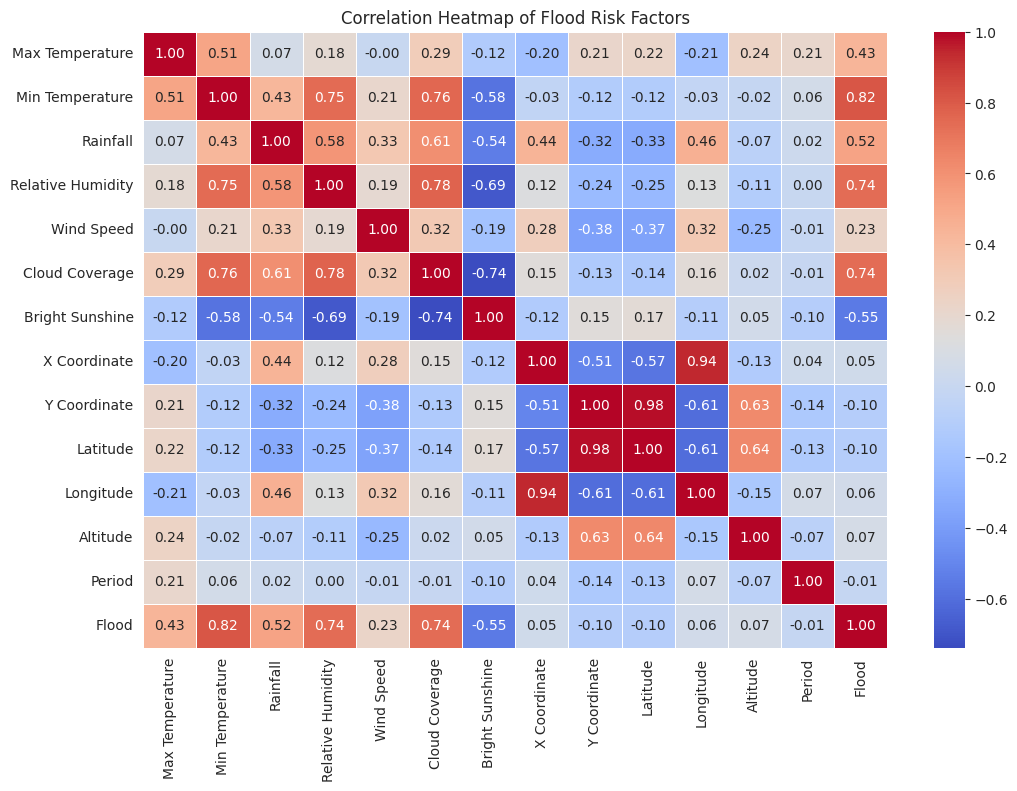

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


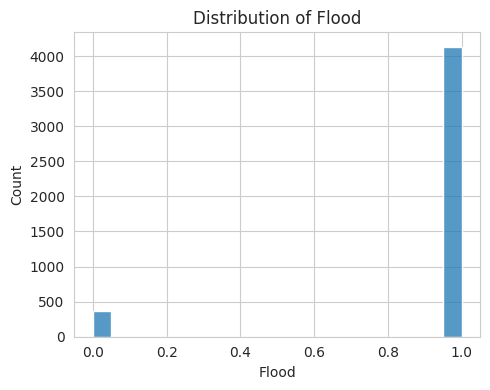

In [7]:
# Correlation Heatmap
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.heatmap(df_known.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Flood Risk Factors")
plt.show()

# Bar Chart:
columns_to_plot = ['Flood']

# Plot
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(5, 4 * len(columns_to_plot)))
if len(columns_to_plot) == 1:
    axes = [axes]  # make iterable if only one axis

for col, ax in zip(columns_to_plot, axes):
    sns.histplot(df_known[col], bins=20, kde=False, ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print(Y_train.mean())
print(Y_test.mean())

0.9259141494435612
0.8466666666666667


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [11]:
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

linear_model.coef_

array([ 0.02595231,  0.13957368,  0.03108704,  0.03751259,  0.01619501,
        0.02038678, -0.00371448,  0.07024444,  0.27768366, -0.29050081,
       -0.0746175 ,  0.0320514 , -0.0043725 ])

In [12]:
test_prediction = linear_model.predict(X_test)
multiple_regression_MSE = mean_squared_error(Y_test, test_prediction)
print(multiple_regression_MSE)

0.10430537464855466


In [13]:
test_prediction_rounded = np.round(test_prediction)
accuracy = np.mean(test_prediction_rounded == Y_test) * 100
print(f"Rounded accuracy: {accuracy:.2f}%")

Rounded accuracy: 91.78%


In [14]:
def Poly_Regression(degree):
  poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  poly_model.fit(X_train, Y_train)
  poly_test_prediction = poly_model.predict(X_test)
  polynomial_regression_MSE = mean_squared_error(Y_test, poly_test_prediction)
  print(f"Mean squared error for degree = {degree}: {polynomial_regression_MSE}")

In [15]:
for i in range(1,4):
  Poly_Regression(i)


Mean squared error for degree = 1: 0.1043053746485549
Mean squared error for degree = 2: 59734820.14711355
Mean squared error for degree = 3: 2.101842763368921e+19


Validation Accuracy: 0.9866369710467706


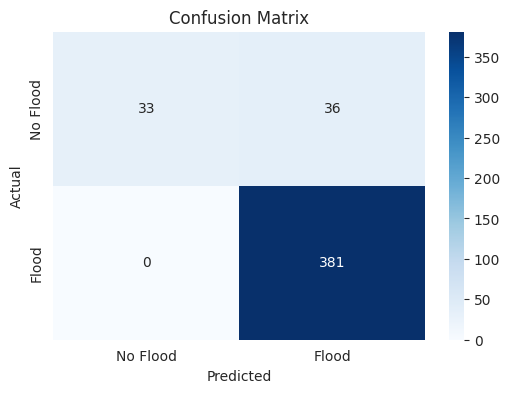

In [16]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)
print("Validation Accuracy:", model.score(X_valid, Y_valid))
Y_pred = model.predict(X_test)
# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)
from tensorflow import keras
from keras import regularizers

def compute_and_display_metrics(name, y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Flood','Flood'],
                yticklabels=['No Flood','Flood'])
    plt.title(f'{name} — Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    p, r, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0,1], zero_division=0
    )
    df_known = pd.DataFrame({
        'precision': p,
        'recall':    r,
        'f1-score':  f1,
        'support':   support
    }, index=['No Flood','Flood'])
    df_known.loc['accuracy'] = [np.nan, np.nan, (y_pred==y_true).mean(), len(y_true)]
    print(f'\n{name} classification report:\n')
    display(df_known)

    auc = roc_auc_score(y_true, y_prob)
    print(f'{name} ROC AUC: {auc:.4f}\n')

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

Validation Accuracy: 0.9855233853006682


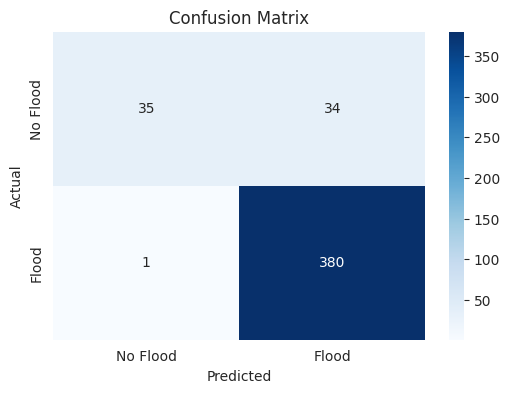

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
model = RandomForestClassifier(random_state=42)
model.fit(X_train, Y_train)
print("Validation Accuracy:", model.score(X_valid, Y_valid))
Y_pred = model.predict(X_test)
# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
fi_df = feature_importance_rf(model, feature_names=list(X.columns), top_n=20)
print(fi_df)

              feature  importance
0            Rainfall    0.290148
1     Min Temperature    0.150979
2      Cloud Coverage    0.134184
3     Bright Sunshine    0.111079
4   Relative Humidity    0.094886
5            Altitude    0.037080
6        Y Coordinate    0.035874
7     Max Temperature    0.035200
8            Latitude    0.034098
9        X Coordinate    0.028982
10         Wind Speed    0.025246
11          Longitude    0.018443
12             Period    0.003800


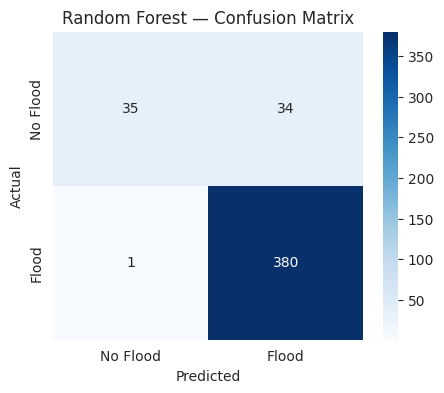


Random Forest classification report:



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,precision,recall,f1-score,support
No Flood,0.972222,0.507246,0.666667,69.0
Flood,0.917874,0.997375,0.955975,381.0
accuracy,NaN,NaN,0.922222,450.0


Random Forest ROC AUC: 0.9862



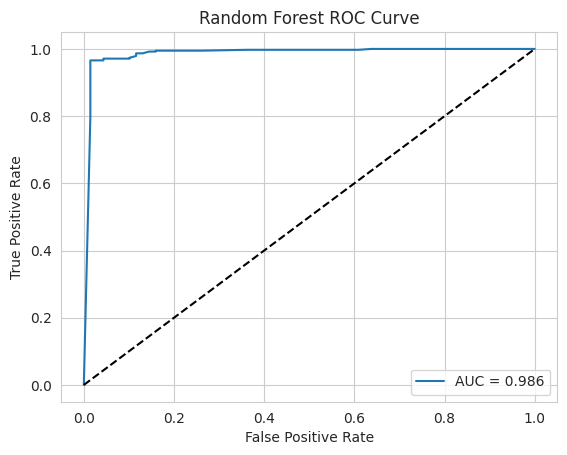

In [20]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, Y_train)

Y_pred_rf  = rf.predict(X_test)
Y_prob_rf  = rf.predict_proba(X_test)[:,1]

compute_and_display_metrics(
    'Random Forest',
    y_true  = Y_test,
    y_pred  = Y_pred_rf,
    y_prob  = Y_prob_rf
)


In [21]:
import tensorflow as tf

In [22]:
from tensorflow import keras
from keras import regularizers

def try_model(layers = 1, neurons = 30):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))

  for i in range(layers):
    model.add(tf.keras.layers.Dense(neurons, activation="relu",kernel_regularizer=regularizers.l2(0.001)))

    # if i % 2 == 0:
      # model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
  model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall   (name='recall'),
            keras.metrics.AUC      (name='auc'),
        ]
    )
  return model

I0000 00:00:1757774340.607680      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757774340.608453      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Number of layers: 4  Number of neurons: 20
Epoch 1/100


I0000 00:00:1757774345.466532     104 service.cc:148] XLA service 0x7c4bc4004550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757774345.467889     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757774345.467909     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757774345.911048     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


60/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - auc: 0.7485 - loss: 0.6698 - precision: 0.9230 - recall: 0.8660

I0000 00:00:1757774347.283225     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8467 - auc: 0.7524 - loss: 0.5946 - precision: 0.9252 - recall: 0.9066 - val_accuracy: 0.9343 - val_auc: 0.9857 - val_loss: 0.1794 - val_precision: 0.9343 - val_recall: 1.0000
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9774 - auc: 0.9980 - loss: 0.1344 - precision: 0.9767 - recall: 0.9996 - val_accuracy: 0.9788 - val_auc: 0.9784 - val_loss: 0.1332 - val_precision: 0.9790 - val_recall: 0.9988
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9966 - auc: 0.9994 - loss: 0.0760 - precision: 0.9972 - recall: 0.9991 - val_accuracy: 0.9788 - val_auc: 0.9619 - val_loss: 0.1439 - val_precision: 0.9790 - val_recall: 0.9988
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - auc: 0.9996 - loss: 0.0640 - precision: 0.9976 - recall: 1.0000 - val_accuracy: 0.9800 - val_auc: 0.9209 - val_loss: 0.1502 - val_precision: 0.9801 - val_recall: 0.9988
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

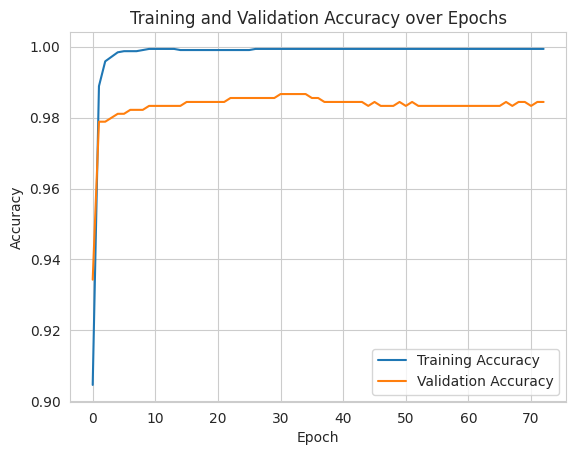

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.8902, Recall: 1.0000, F1: 0.9419, AUC: 0.7853
Number of layers: 4  Number of neurons: 30
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9240 - auc: 0.7470 - loss: 0.4747 - precision: 0.9254 - recall: 0.9982 - val_accuracy: 0.9788 - val_auc: 0.9914 - val_loss: 0.1631 - val_precision: 0.9790 - val_recall: 0.9988
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9916 - auc: 0.9987 - loss: 0.1276 - precision: 0.9934 - recall: 0.9976 - val_accuracy: 0.9788 - val_auc: 0.9785 - val_loss: 0.1546 - val_precision: 0.9801 - val_recall: 0.9976
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - auc: 0.9997 - loss: 0.0882 - precision: 0.9965 - recall: 0.9985 - val_accuracy: 0.9811 - val_auc: 0.9547 - val_loss: 0.1574 - val_precision: 0.9813 - val_recall: 0.9988
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - auc: 0.9999 - loss: 0

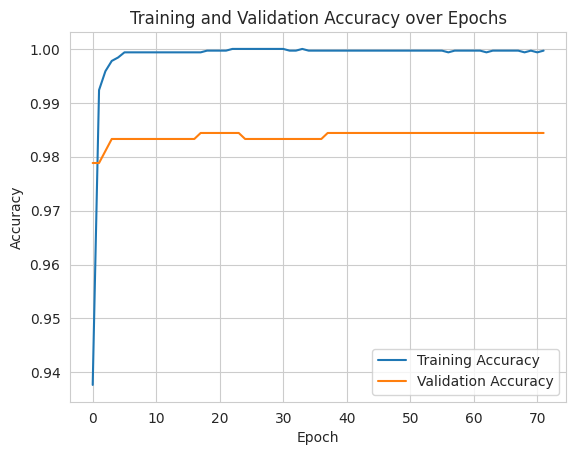

Max validation accuracy for this model: 0.9844098091125488
Validation metrics -> Precision: 0.8902, Recall: 1.0000, F1: 0.9419, AUC: 0.7585
Number of layers: 4  Number of neurons: 40
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9401 - auc: 0.8371 - loss: 0.4294 - precision: 0.9395 - recall: 0.9998 - val_accuracy: 0.9822 - val_auc: 0.9780 - val_loss: 0.1787 - val_precision: 0.9824 - val_recall: 0.9988
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9956 - auc: 0.9994 - loss: 0.1258 - precision: 0.9957 - recall: 0.9995 - val_accuracy: 0.9800 - val_auc: 0.9545 - val_loss: 0.1814 - val_precision: 0.9801 - val_recall: 0.9988
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - auc: 0.9999 - loss: 0.0961 - precision: 0.9983 - recall: 1.0000 - val_accuracy: 0.9811 - val_auc: 0.9464 - val_loss: 0.1712 - val_precision: 0.9801 - val_recall: 1.0000
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - auc: 0.9999 - loss: 0

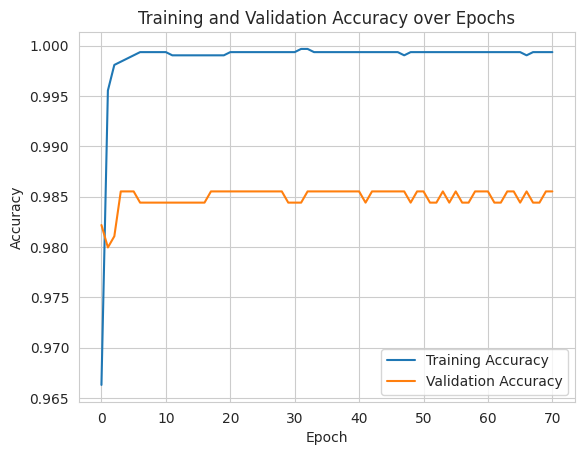

Max validation accuracy for this model: 0.9855234026908875
Validation metrics -> Precision: 0.8923, Recall: 1.0000, F1: 0.9431, AUC: 0.7701
Number of layers: 4  Number of neurons: 60
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8408 - auc: 0.8882 - loss: 0.5345 - precision: 0.9648 - recall: 0.8597 - val_accuracy: 0.9822 - val_auc: 0.9809 - val_loss: 0.2034 - val_precision: 0.9824 - val_recall: 0.9988
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - auc: 0.9995 - loss: 0.1551 - precision: 0.9974 - recall: 0.9987 - val_accuracy: 0.9822 - val_auc: 0.9628 - val_loss: 0.1854 - val_precision: 0.9824 - val_recall: 0.9988
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - auc: 0.9999 - loss: 0.1139 - precision: 0.9988 - recall: 0.9996 - val_accuracy: 0.9833 - val_auc: 0.9452 - val_loss: 0.1767 - val_precision: 0.9836 - val_recall: 0.9988
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - auc: 1.0000 - loss: 0

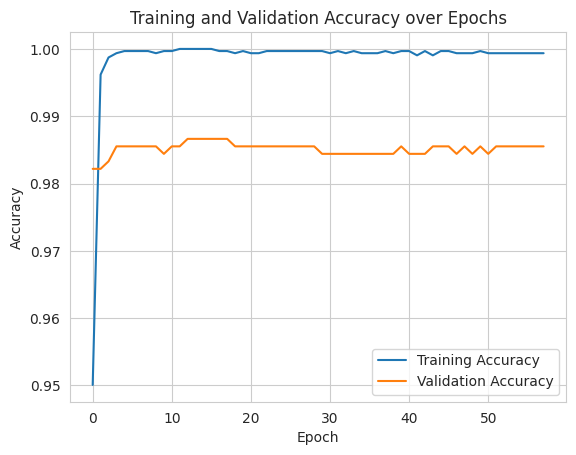

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.8902, Recall: 1.0000, F1: 0.9419, AUC: 0.7665
Number of layers: 6  Number of neurons: 20
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6987 - auc: 0.9442 - loss: 0.6687 - precision: 0.9650 - recall: 0.6770 - val_accuracy: 0.9855 - val_auc: 0.9874 - val_loss: 0.1483 - val_precision: 0.9870 - val_recall: 0.9976
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9903 - auc: 0.9961 - loss: 0.1227 - precision: 0.9933 - recall: 0.9963 - val_accuracy: 0.9844 - val_auc: 0.9807 - val_loss: 0.1492 - val_precision: 0.9847 - val_recall: 0.9988
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - auc: 0.9971 - loss: 0.0967 - precision: 0.9972 - recall: 0.9985 - val_accuracy: 0.9800 - val_auc: 0.9559 - val_loss: 0.1596 - val_precision: 0.9801 - val_recall: 0.9988
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - auc: 0.9973 - loss: 0

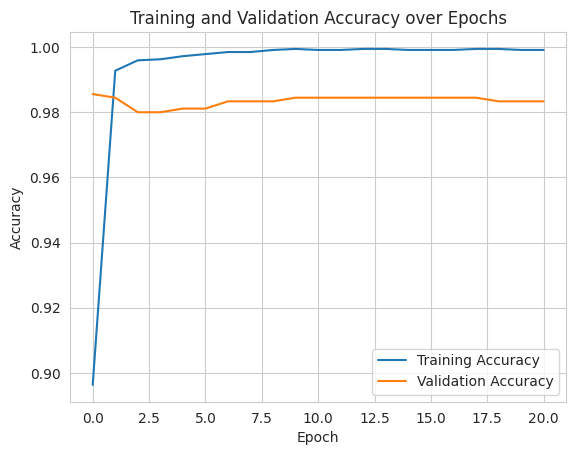

Max validation accuracy for this model: 0.9855234026908875
Validation metrics -> Precision: 0.9137, Recall: 1.0000, F1: 0.9549, AUC: 0.9611
Number of layers: 6  Number of neurons: 30
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8227 - auc: 0.7705 - loss: 0.5665 - precision: 0.9398 - recall: 0.8610 - val_accuracy: 0.9822 - val_auc: 0.9636 - val_loss: 0.2051 - val_precision: 0.9835 - val_recall: 0.9976
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9942 - auc: 0.9924 - loss: 0.1496 - precision: 0.9953 - recall: 0.9984 - val_accuracy: 0.9855 - val_auc: 0.9727 - val_loss: 0.1738 - val_precision: 0.9859 - val_recall: 0.9988
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - auc: 0.9974 - loss: 0.1147 - precision: 0.9983 - recall: 0.9989 - val_accuracy: 0.9822 - val_auc: 0.9641 - val_loss: 0.1727 - val_precision: 0.9824 - val_recall: 0.9988
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - auc: 0.9975 - loss: 0

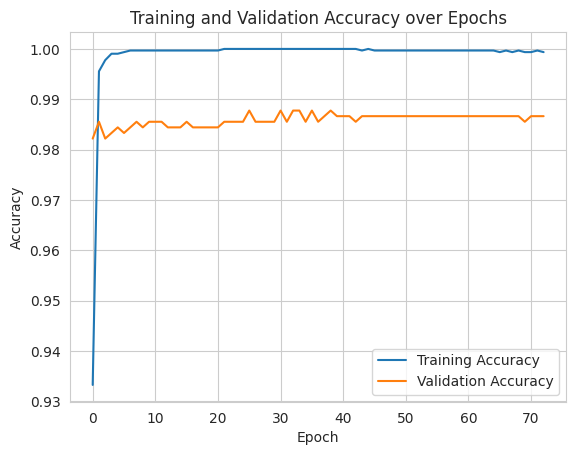

Max validation accuracy for this model: 0.9877505302429199
Validation metrics -> Precision: 0.8902, Recall: 1.0000, F1: 0.9419, AUC: 0.7763
Number of layers: 6  Number of neurons: 40
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8764 - auc: 0.9270 - loss: 0.6046 - precision: 0.9703 - recall: 0.8941 - val_accuracy: 0.9800 - val_auc: 0.9404 - val_loss: 0.2283 - val_precision: 0.9790 - val_recall: 1.0000
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9958 - auc: 0.9970 - loss: 0.1522 - precision: 0.9973 - recall: 0.9982 - val_accuracy: 0.9811 - val_auc: 0.9486 - val_loss: 0.2036 - val_precision: 0.9801 - val_recall: 1.0000
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - auc: 0.9975 - loss: 0.1110 - precision: 0.9981 - recall: 0.9991 - val_accuracy: 0.9811 - val_auc: 0.9060 - val_loss: 0.1973 - val_precision: 0.9801 - val_recall: 1.0000
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - auc: 0.9998 - loss: 0

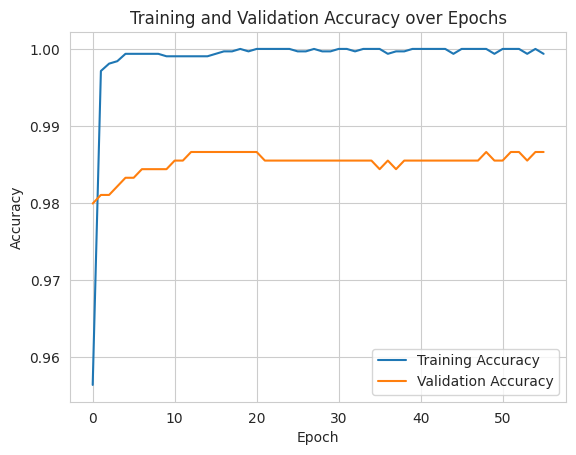

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.8881, Recall: 1.0000, F1: 0.9407, AUC: 0.7826
Number of layers: 6  Number of neurons: 60
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9246 - auc: 0.8333 - loss: 0.5656 - precision: 0.9513 - recall: 0.9682 - val_accuracy: 0.9788 - val_auc: 0.9213 - val_loss: 0.3531 - val_precision: 0.9779 - val_recall: 1.0000
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - auc: 0.9974 - loss: 0.1971 - precision: 0.9986 - recall: 0.9985 - val_accuracy: 0.9855 - val_auc: 0.9208 - val_loss: 0.2600 - val_precision: 0.9847 - val_recall: 1.0000
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - auc: 0.9999 - loss: 0.1375 - precision: 0.9995 - recall: 0.9998 - val_accuracy: 0.9855 - val_auc: 0.9211 - val_loss: 0.2411 - val_precision: 0.9847 - val_recall: 1.0000
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - auc: 1.0000 - loss: 0

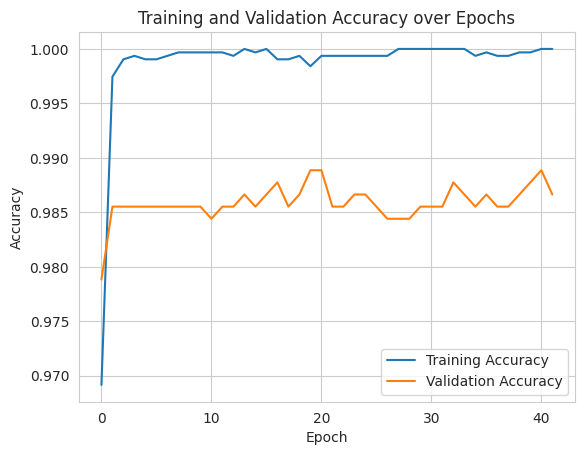

Max validation accuracy for this model: 0.9888641238212585
Validation metrics -> Precision: 0.8965, Recall: 1.0000, F1: 0.9454, AUC: 0.8486
Number of layers: 8  Number of neurons: 20
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8513 - auc: 0.6854 - loss: 0.6762 - precision: 0.9286 - recall: 0.9006 - val_accuracy: 0.9878 - val_auc: 0.9980 - val_loss: 0.1698 - val_precision: 0.9905 - val_recall: 0.9964
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9914 - auc: 0.9990 - loss: 0.1499 - precision: 0.9954 - recall: 0.9952 - val_accuracy: 0.9844 - val_auc: 0.9803 - val_loss: 0.1476 - val_precision: 0.9905 - val_recall: 0.9928
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9953 - auc: 0.9998 - loss: 0.1060 - precision: 0.9977 - recall: 0.9972 - val_accuracy: 0.9844 - val_auc: 0.9467 - val_loss: 0.1809 - val_precision: 0.9859 - val_recall: 0.9976
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - auc: 0.9998 - loss: 

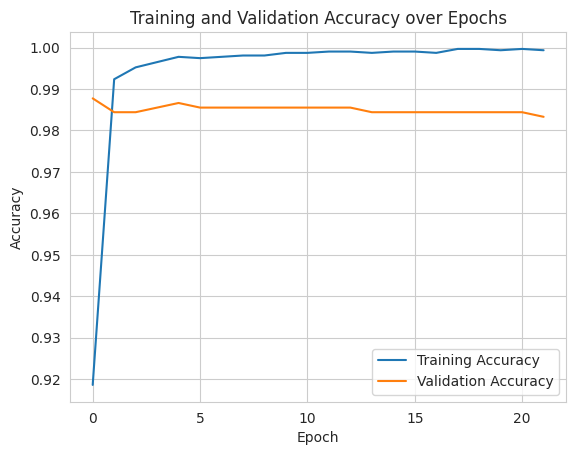

Max validation accuracy for this model: 0.9877505302429199
Validation metrics -> Precision: 0.9335, Recall: 0.9948, F1: 0.9632, AUC: 0.9520
Number of layers: 8  Number of neurons: 30
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8768 - auc: 0.7306 - loss: 0.5771 - precision: 0.9323 - recall: 0.9304 - val_accuracy: 0.9889 - val_auc: 0.9822 - val_loss: 0.2084 - val_precision: 0.9894 - val_recall: 0.9988
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9897 - auc: 0.9945 - loss: 0.1842 - precision: 0.9943 - recall: 0.9945 - val_accuracy: 0.9878 - val_auc: 0.9826 - val_loss: 0.1695 - val_precision: 0.9871 - val_recall: 1.0000
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9942 - auc: 0.9996 - loss: 0.1388 - precision: 0.9976 - recall: 0.9961 - val_accuracy: 0.9878 - val_auc: 0.9739 - val_loss: 0.1575 - val_precision: 0.9871 - val_recall: 1.0000
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - auc: 0.9998 - loss: 0

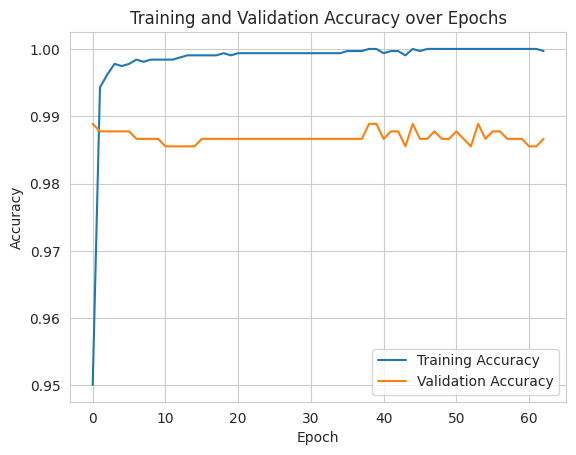

Max validation accuracy for this model: 0.9888641238212585
Validation metrics -> Precision: 0.8881, Recall: 1.0000, F1: 0.9407, AUC: 0.7022
Number of layers: 8  Number of neurons: 40
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9374 - auc: 0.7238 - loss: 0.5718 - precision: 0.9373 - recall: 0.9994 - val_accuracy: 0.9788 - val_auc: 0.9061 - val_loss: 0.3202 - val_precision: 0.9790 - val_recall: 0.9988
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9934 - auc: 0.9949 - loss: 0.1955 - precision: 0.9951 - recall: 0.9977 - val_accuracy: 0.9788 - val_auc: 0.9055 - val_loss: 0.2937 - val_precision: 0.9779 - val_recall: 1.0000
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - auc: 0.9999 - loss: 0.1371 - precision: 0.9986 - recall: 0.9999 - val_accuracy: 0.9822 - val_auc: 0.9225 - val_loss: 0.2601 - val_precision: 0.9813 - val_recall: 1.0000
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0

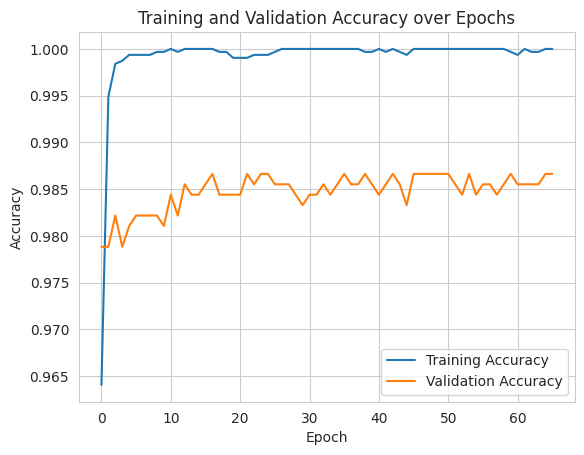

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.8923, Recall: 1.0000, F1: 0.9431, AUC: 0.7033
Number of layers: 8  Number of neurons: 60
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9365 - auc: 0.7668 - loss: 0.6734 - precision: 0.9374 - recall: 0.9981 - val_accuracy: 0.9777 - val_auc: 0.9233 - val_loss: 0.3757 - val_precision: 0.9767 - val_recall: 1.0000
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9935 - auc: 0.9973 - loss: 0.2207 - precision: 0.9957 - recall: 0.9973 - val_accuracy: 0.9866 - val_auc: 0.9470 - val_loss: 0.2446 - val_precision: 0.9859 - val_recall: 1.0000
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.1451 - precision: 0.9996 - recall: 0.9991 - val_accuracy: 0.9844 - val_auc: 0.9467 - val_loss: 0.2098 - val_precision: 0.9870 - val_recall: 0.9964
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9962 - auc: 0.9998 - loss: 0

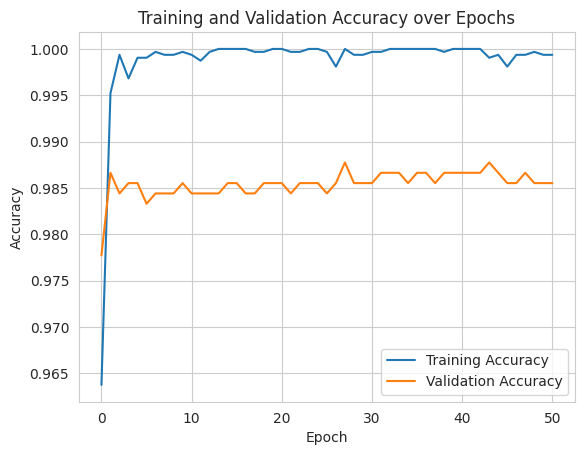

Max validation accuracy for this model: 0.9877505302429199
Validation metrics -> Precision: 0.8944, Recall: 1.0000, F1: 0.9442, AUC: 0.7315
Number of layers: 10  Number of neurons: 20
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9240 - auc: 0.5370 - loss: 0.6404 - precision: 0.9240 - recall: 1.0000 - val_accuracy: 0.9343 - val_auc: 0.9947 - val_loss: 0.2510 - val_precision: 0.9343 - val_recall: 1.0000
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9244 - auc: 0.9974 - loss: 0.2115 - precision: 0.9243 - recall: 1.0000 - val_accuracy: 0.9766 - val_auc: 0.9802 - val_loss: 0.2031 - val_precision: 0.9756 - val_recall: 1.0000
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9937 - auc: 0.9988 - loss: 0.1574 - precision: 0.9953 - recall: 0.9978 - val_accuracy: 0.9788 - val_auc: 0.9632 - val_loss: 0.1837 - val_precision: 0.9790 - val_recall: 0.9988
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - auc: 0.9997 - loss:

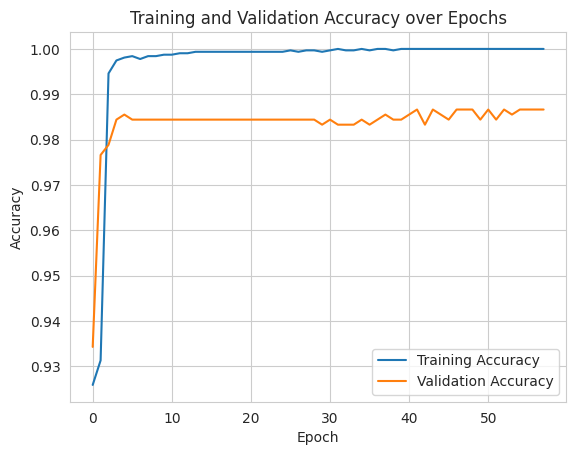

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.8799, Recall: 1.0000, F1: 0.9361, AUC: 0.7452
Number of layers: 10  Number of neurons: 30
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8771 - auc: 0.7075 - loss: 0.7256 - precision: 0.9328 - recall: 0.9244 - val_accuracy: 0.9755 - val_auc: 0.8811 - val_loss: 0.3636 - val_precision: 0.9756 - val_recall: 0.9988
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - auc: 0.9925 - loss: 0.1849 - precision: 0.9954 - recall: 0.9982 - val_accuracy: 0.9800 - val_auc: 0.9225 - val_loss: 0.2972 - val_precision: 0.9801 - val_recall: 0.9988
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - auc: 0.9973 - loss: 0.1358 - precision: 0.9975 - recall: 0.9993 - val_accuracy: 0.9822 - val_auc: 0.9227 - val_loss: 0.2659 - val_precision: 0.9824 - val_recall: 0.9988
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - auc: 0.9998 - loss:

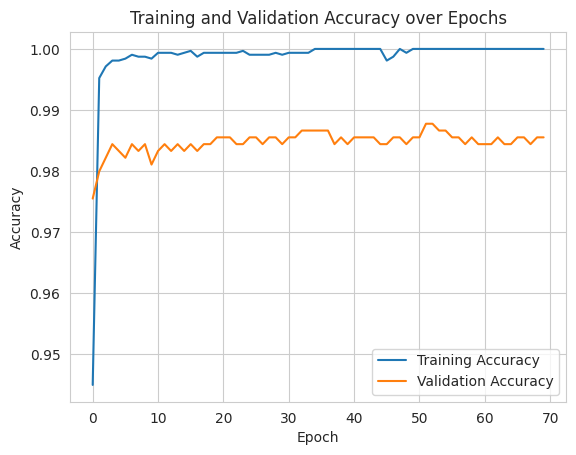

Max validation accuracy for this model: 0.9877505302429199
Validation metrics -> Precision: 0.8944, Recall: 1.0000, F1: 0.9442, AUC: 0.6859
Number of layers: 10  Number of neurons: 40
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9014 - auc: 0.6631 - loss: 0.6907 - precision: 0.9218 - recall: 0.9753 - val_accuracy: 0.9777 - val_auc: 0.9638 - val_loss: 0.3239 - val_precision: 0.9801 - val_recall: 0.9964
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9944 - auc: 0.9985 - loss: 0.2627 - precision: 0.9972 - recall: 0.9967 - val_accuracy: 0.9777 - val_auc: 0.9205 - val_loss: 0.3273 - val_precision: 0.9789 - val_recall: 0.9976
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - auc: 0.9994 - loss: 0.1652 - precision: 0.9976 - recall: 0.9962 - val_accuracy: 0.9822 - val_auc: 0.9208 - val_loss: 0.2600 - val_precision: 0.9847 - val_recall: 0.9964
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - auc: 1.0000 - loss:

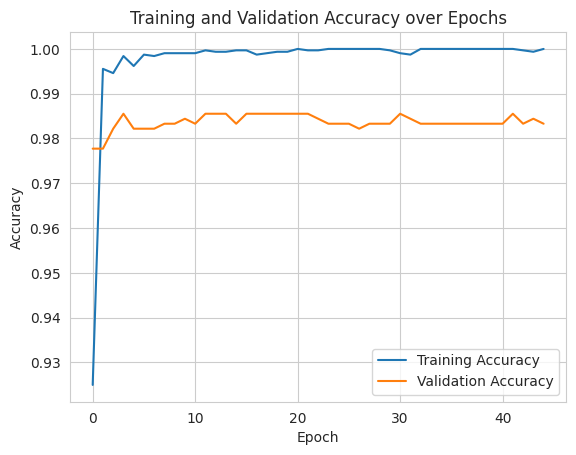

Max validation accuracy for this model: 0.9855234026908875
Validation metrics -> Precision: 0.8923, Recall: 1.0000, F1: 0.9431, AUC: 0.7359
Number of layers: 10  Number of neurons: 60
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9254 - auc: 0.7733 - loss: 0.7561 - precision: 0.9253 - recall: 1.0000 - val_accuracy: 0.9766 - val_auc: 0.9525 - val_loss: 0.3849 - val_precision: 0.9767 - val_recall: 0.9988
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - auc: 0.9998 - loss: 0.2778 - precision: 0.9962 - recall: 1.0000 - val_accuracy: 0.9777 - val_auc: 0.9128 - val_loss: 0.3001 - val_precision: 0.9778 - val_recall: 0.9988
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - auc: 0.9998 - loss: 0.1479 - precision: 0.9987 - recall: 0.9997 - val_accuracy: 0.9811 - val_auc: 0.9140 - val_loss: 0.2744 - val_precision: 0.9813 - val_recall: 0.9988
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9983 - auc: 0.9999 - loss:

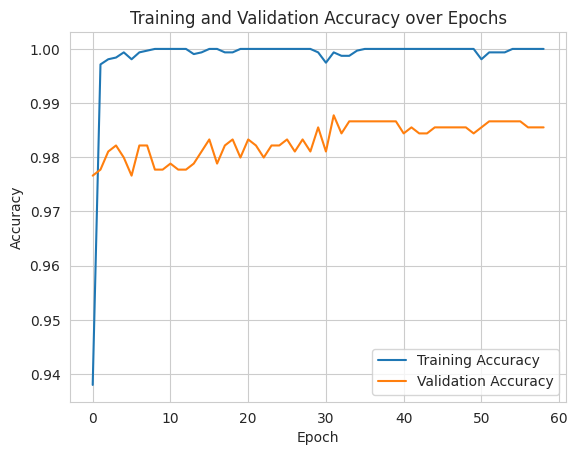

Max validation accuracy for this model: 0.9877505302429199
Validation metrics -> Precision: 0.8860, Recall: 1.0000, F1: 0.9396, AUC: 0.7518
Best validation accuracy: 0.9888641238212585
Best configuration: (6, 60)


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import time
import matplotlib.pyplot as plt

layer_count = [4, 6, 8, 10]
neuron_count = [20, 30, 40,50, 60]
results = []

best_val_acc = 0
best_config = None

for layers in layer_count:
    for neurons in neuron_count:
        model = try_model(layers, neurons)
        print("Number of layers:", layers, " Number of neurons:", neurons)

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )
        history = model.fit(
            X_train, Y_train,
            epochs=100,
            validation_data=(X_valid, Y_valid),
            callbacks=[early_stopping],
            verbose=1
        )

        # optional: plot accuracy history
        plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
        plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
        plt.title('Training and Validation Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

        # get best validation accuracy from history (as before)
        val_acc = max(history.history.get('val_accuracy', [0]))
        print("Max validation accuracy for this model:", val_acc)

        # --- compute detailed metrics on the validation set ---
        # Use the same validation set you passed earlier (X_test/Y_test)
        X_val = X_test
        Y_val = Y_test

        # probabilities and predictions (threshold = 0.3)
        y_prob = model.predict(X_val, verbose=0).ravel()           
        y_pred = (y_prob >= 0.3).astype(int)    # threshold at 0.3

        prec = precision_score(Y_val, y_pred, zero_division=0)
        rec  = recall_score   (Y_val, y_pred, zero_division=0)
        f1   = f1_score       (Y_val, y_pred, zero_division=0)

        # AUC might fail if only one class is present; handle safely
        try:
            auc = roc_auc_score(Y_val, y_prob)
        except ValueError:
            auc = float('nan')

        print(f"Validation metrics -> Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

        # keep best config by validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = (layers, neurons)

print("Best validation accuracy:", best_val_acc)
print("Best configuration:", best_config)


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

pw2 = [2, 4, 8, 16, 32, 64, 128, 256, 512]

def try_model_pw2_funnel(layers=1, start=0):
    """
    Funnel: uses descending powers starting at index (start + layers - 1) downwards.
    Output: 2-way softmax (suitable for sparse_categorical_crossentropy).
    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))
    end = start + layers - 1
    print("Layer sizes:", end=' ')
    for i in range(layers):
        size = pw2[end - i]           # descending funnel
        model.add(tf.keras.layers.Dense(size, activation='relu'))
        # model.add(tf.keras.layers.Dropout(0.2))
        print(size, end=' ')
    print()
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [25]:

def try_model_pw2(layers=1, start=0):
    """
    Ascending from pw2[start] upward for 'layers' layers.
    Output: single-sigmoid (binary).
    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))
    print("Layer sizes:", end=' ')
    for i in range(layers):
        size = pw2[i + start]        # corrected indexing
        model.add(tf.keras.layers.Dense(size, activation='relu'))
        if (i % 2 == 0):
            model.add(tf.keras.layers.Dropout(0.1))
        print(size, end=' ')
    print()
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


Layer sizes: 16 8 4 2 
Number of layers: 4
Starting position: 0
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8929 - loss: 0.6180 - val_accuracy: 0.9343 - val_loss: 0.2837
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.2153 - val_accuracy: 0.9343 - val_loss: 0.1007
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.0998 - val_accuracy: 0.9343 - val_loss: 0.0947
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.0836 - val_accuracy: 0.9343 - val_loss: 0.0955
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.0753 - val_accuracy: 0.9343 - val_loss: 0.0981
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.0687 - val_accuracy: 0.9343 - val_loss: 0.1006
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.0631 - val_accuracy: 0.9666 - val_loss: 0.1055
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

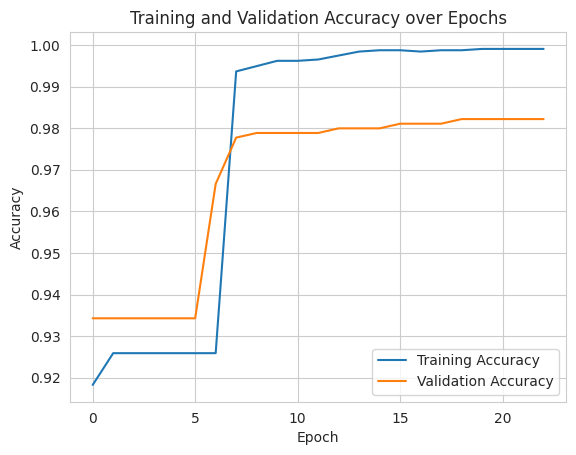

Max validation accuracy for this model: 0.9821826219558716
Validation metrics -> Precision: 0.9343, Recall: 1.0000, F1: 0.9660, AUC: 0.9956
Layer sizes: 32 16 8 4 
Number of layers: 4
Starting position: 1
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4740 - loss: 0.7333 - val_accuracy: 0.9889 - val_loss: 0.5760
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9869 - loss: 0.4802 - val_accuracy: 0.9878 - val_loss: 0.1123
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9892 - loss: 0.0681 - val_accuracy: 0.9855 - val_loss: 0.0428
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0202 - val_accuracy: 0.9811 - val_loss: 0.0596
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0107 - val_accuracy: 0.9822 - val_loss: 0.0742
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0071 - val_accuracy: 0.9833 - val_loss: 0.0881
Epoch 7/100
99/99 ━━━━━━━━━━━━━━

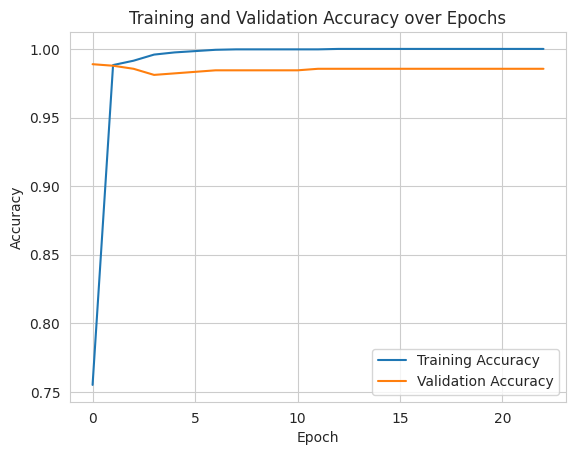

Max validation accuracy for this model: 0.9888641238212585
Validation metrics -> Precision: 0.9859, Recall: 0.9988, F1: 0.9923, AUC: 0.9964
Layer sizes: 64 32 16 8 
Number of layers: 4
Starting position: 2
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9240 - loss: 0.2929 - val_accuracy: 0.9343 - val_loss: 0.1002
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9333 - loss: 0.0638 - val_accuracy: 0.9800 - val_loss: 0.1237
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0300 - val_accuracy: 0.9833 - val_loss: 0.1419
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0050 - val_accuracy: 0.9833 - val_loss: 0.1823
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0025 - val_accuracy: 0.9833 - val_loss: 0.2062
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9833 - val_loss: 0.2310
Epoch 7/100
99/99 ━━━━━━━━━━━━━

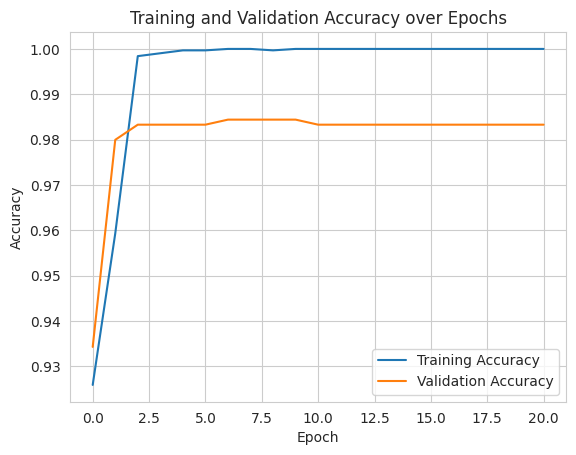

Max validation accuracy for this model: 0.9844098091125488
Validation metrics -> Precision: 0.9343, Recall: 1.0000, F1: 0.9660, AUC: 0.9834
Layer sizes: 128 64 32 16 
Number of layers: 4
Starting position: 3
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9551 - loss: 0.2666 - val_accuracy: 0.9800 - val_loss: 0.0801
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0131 - val_accuracy: 0.9844 - val_loss: 0.1036
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0064 - val_accuracy: 0.9844 - val_loss: 0.1476
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0032 - val_accuracy: 0.9855 - val_loss: 0.1808
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9866 - val_loss: 0.2065
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9855 - val_loss: 0.2336
Epoch 7/100
99/99 ━━━━━━━━━━━

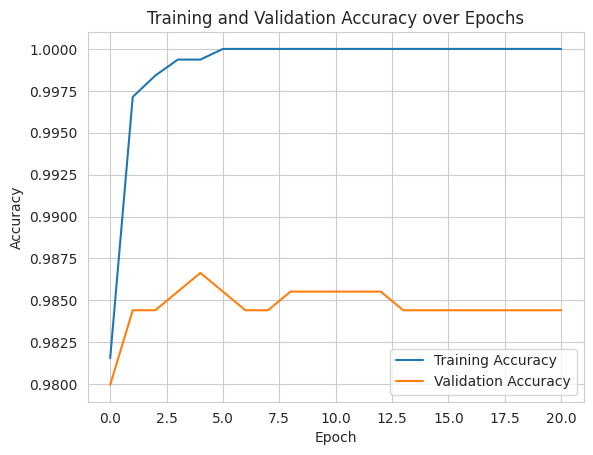

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.9801, Recall: 0.9988, F1: 0.9894, AUC: 0.9814
Layer sizes: 256 128 64 32 
Number of layers: 4
Starting position: 4
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9470 - loss: 0.1634 - val_accuracy: 0.9822 - val_loss: 0.0996
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0083 - val_accuracy: 0.9844 - val_loss: 0.1785
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.0061 - val_accuracy: 0.9844 - val_loss: 0.2310
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9844 - val_loss: 0.2668
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.5481e-04 - val_accuracy: 0.9844 - val_loss: 0.2917
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0017 - val_accuracy: 0.9855 - val_loss: 0.2957
Epoch 7/100
99/99 ━━━━━━

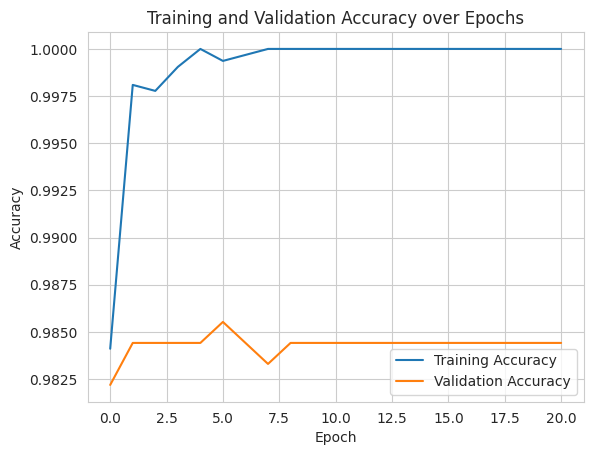

Max validation accuracy for this model: 0.9855234026908875
Validation metrics -> Precision: 0.9824, Recall: 0.9988, F1: 0.9905, AUC: 0.9750
Layer sizes: 512 256 128 64 
Number of layers: 4
Starting position: 5
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9831 - loss: 0.1157 - val_accuracy: 0.9844 - val_loss: 0.1850
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0061 - val_accuracy: 0.9866 - val_loss: 0.2617
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0031 - val_accuracy: 0.9833 - val_loss: 0.3307
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0015 - val_accuracy: 0.9866 - val_loss: 0.3563
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.9559e-04 - val_accuracy: 0.9844 - val_loss: 0.3667
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0065 - val_accuracy: 0.9855 - val_loss: 0.5534
Epoch 7/100
99/99 ━━━━━

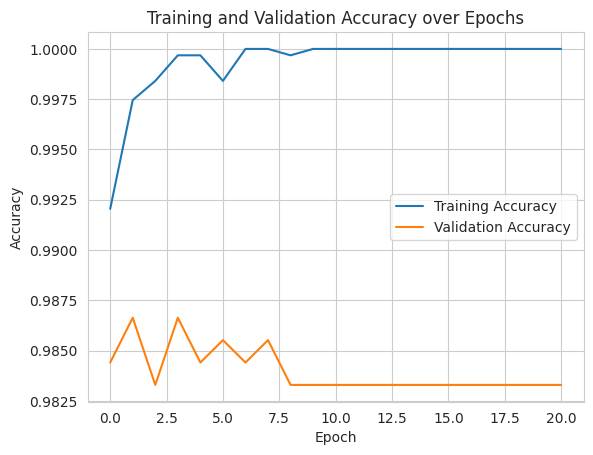

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.9847, Recall: 0.9988, F1: 0.9917, AUC: 0.9374
Layer sizes: 32 16 8 4 2 
Number of layers: 5
Starting position: 0
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9191 - loss: 0.4529 - val_accuracy: 0.9343 - val_loss: 0.0862
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9240 - loss: 0.0834 - val_accuracy: 0.9343 - val_loss: 0.0826
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.0659 - val_accuracy: 0.9343 - val_loss: 0.0910
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9603 - loss: 0.0597 - val_accuracy: 0.9800 - val_loss: 0.1018
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0552 - val_accuracy: 0.9811 - val_loss: 0.1149
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0512 - val_accuracy: 0.9811 - val_loss: 0.1292
Epoch 7/100
99/99 ━━━━━━━━━━━━

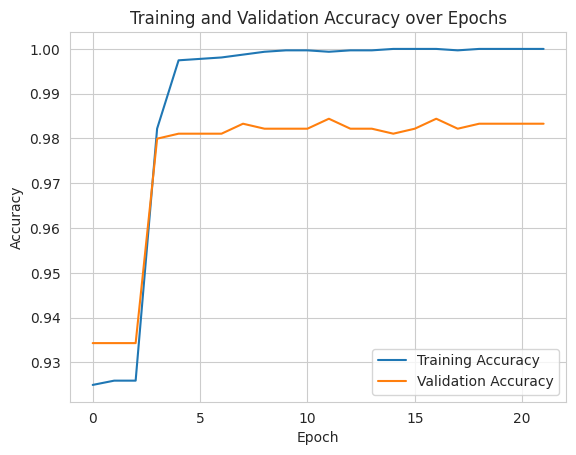

Max validation accuracy for this model: 0.9844098091125488
Validation metrics -> Precision: 0.9343, Recall: 1.0000, F1: 0.9660, AUC: 0.9931
Layer sizes: 64 32 16 8 4 
Number of layers: 5
Starting position: 1
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7111 - loss: 0.6247 - val_accuracy: 0.9788 - val_loss: 0.0670
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0332 - val_accuracy: 0.9811 - val_loss: 0.0805
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0087 - val_accuracy: 0.9844 - val_loss: 0.1037
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0053 - val_accuracy: 0.9844 - val_loss: 0.1342
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0035 - val_accuracy: 0.9844 - val_loss: 0.1571
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 0.9833 - val_loss: 0.1712
Epoch 7/100
99/99 ━━━━━━━━━━━

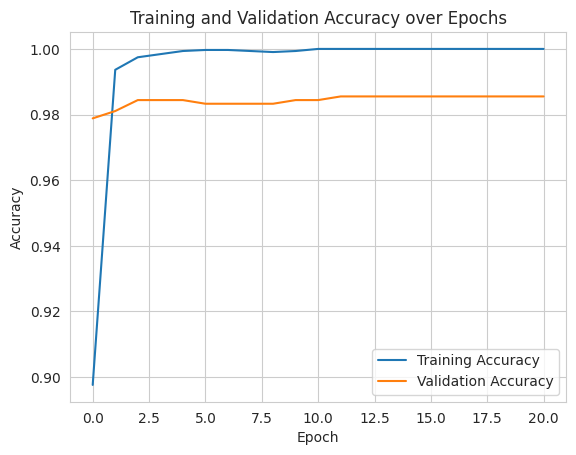

Max validation accuracy for this model: 0.9855234026908875
Validation metrics -> Precision: 0.9790, Recall: 0.9988, F1: 0.9888, AUC: 0.9757
Layer sizes: 128 64 32 16 8 
Number of layers: 5
Starting position: 2
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9226 - loss: 0.2704 - val_accuracy: 0.9811 - val_loss: 0.0759
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.0171 - val_accuracy: 0.9844 - val_loss: 0.1389
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0054 - val_accuracy: 0.9844 - val_loss: 0.1971
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9844 - val_loss: 0.2354
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0016 - val_accuracy: 0.9844 - val_loss: 0.2599
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9293e-04 - val_accuracy: 0.9844 - val_loss: 0.2732
Epoch 7/100
99/99 ━━━━━

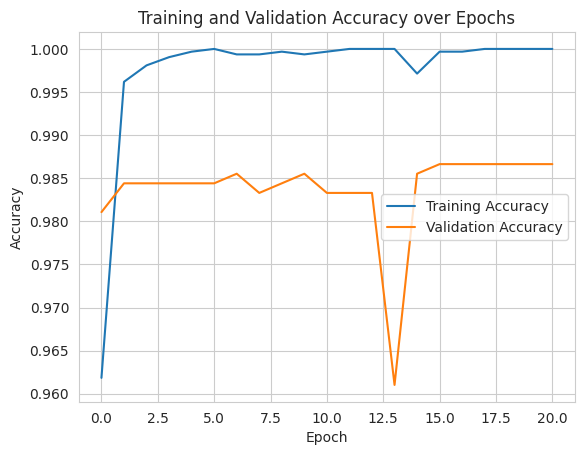

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.9813, Recall: 0.9988, F1: 0.9900, AUC: 0.9898
Layer sizes: 256 128 64 32 16 
Number of layers: 5
Starting position: 3
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9597 - loss: 0.2357 - val_accuracy: 0.9811 - val_loss: 0.1156
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0096 - val_accuracy: 0.9844 - val_loss: 0.1666
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0072 - val_accuracy: 0.9833 - val_loss: 0.1966
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9855 - val_loss: 0.2149
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0022 - val_accuracy: 0.9844 - val_loss: 0.2481
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9833 - val_loss: 0.2895
Epoch 7/100
99/99 ━━━━━━━

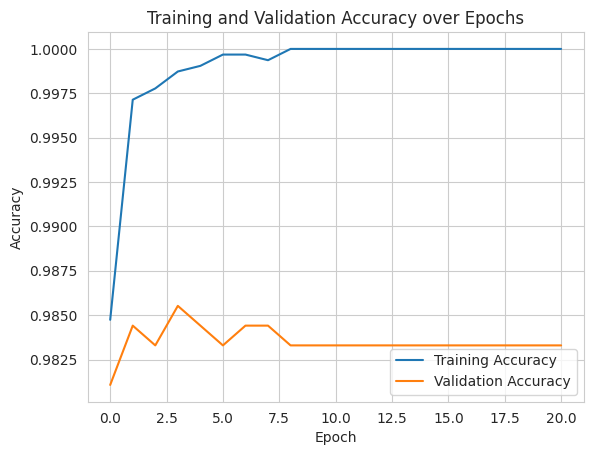

Max validation accuracy for this model: 0.9855234026908875
Validation metrics -> Precision: 0.9801, Recall: 1.0000, F1: 0.9900, AUC: 0.9830
Layer sizes: 512 256 128 64 32 
Number of layers: 5
Starting position: 4
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9621 - loss: 0.1643 - val_accuracy: 0.9844 - val_loss: 0.1321
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0069 - val_accuracy: 0.9855 - val_loss: 0.2184
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0047 - val_accuracy: 0.9855 - val_loss: 0.2221
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0020 - val_accuracy: 0.9855 - val_loss: 0.2954
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0019 - val_accuracy: 0.9866 - val_loss: 0.3034
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9844 - val_loss: 0.3457
Epoch 7/100
99/99 ━━━━━━

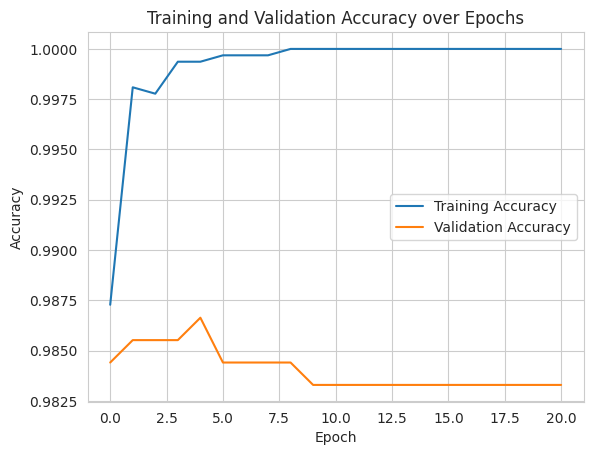

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.9847, Recall: 0.9988, F1: 0.9917, AUC: 0.9678
Layer sizes: 64 32 16 8 4 2 
Number of layers: 6
Starting position: 0
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7671 - loss: 0.6659 - val_accuracy: 0.9855 - val_loss: 0.5771
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9885 - loss: 0.5473 - val_accuracy: 0.9878 - val_loss: 0.5008
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.4701 - val_accuracy: 0.9844 - val_loss: 0.4397
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.4072 - val_accuracy: 0.9855 - val_loss: 0.3861
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.3553 - val_accuracy: 0.9844 - val_loss: 0.3425
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.3108 - val_accuracy: 0.9855 - val_loss: 0.3055
Epoch 7/100
99/99 ━━━━━━━━━

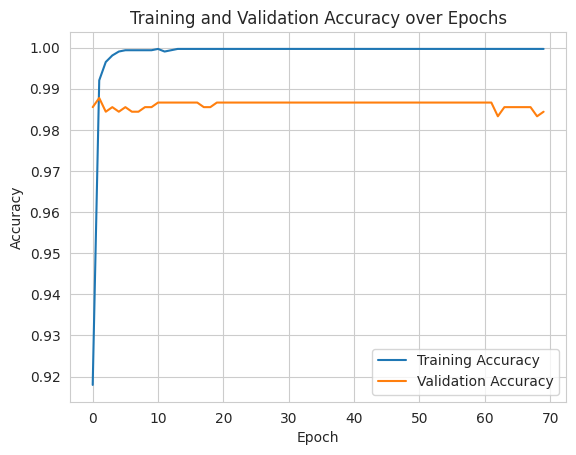

Max validation accuracy for this model: 0.9877505302429199
Validation metrics -> Precision: 0.9859, Recall: 1.0000, F1: 0.9929, AUC: 0.9066
Layer sizes: 128 64 32 16 8 4 
Number of layers: 6
Starting position: 1
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9014 - loss: 0.2998 - val_accuracy: 0.9833 - val_loss: 0.0661
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0093 - val_accuracy: 0.9833 - val_loss: 0.1366
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0034 - val_accuracy: 0.9844 - val_loss: 0.1759
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 0.9855 - val_loss: 0.1801
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9855 - val_loss: 0.2161
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0018 - val_accuracy: 0.9822 - val_loss: 0.2769
Epoch 7/100
99/99 ━━━━━━━

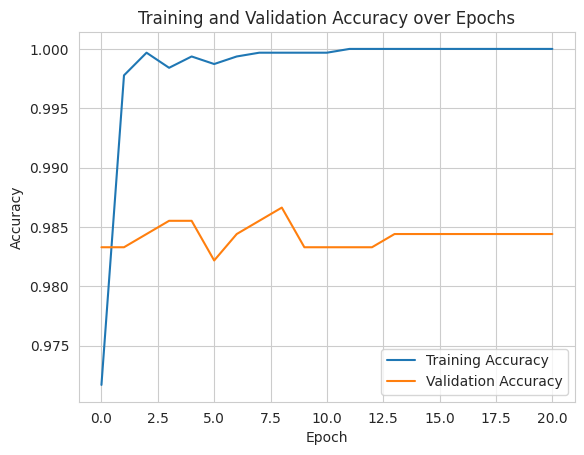

Max validation accuracy for this model: 0.9866369962692261
Validation metrics -> Precision: 0.9824, Recall: 1.0000, F1: 0.9911, AUC: 0.9779
Layer sizes: 256 128 64 32 16 8 
Number of layers: 6
Starting position: 2
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8556 - loss: 0.3186 - val_accuracy: 0.9800 - val_loss: 0.1196
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0082 - val_accuracy: 0.9855 - val_loss: 0.1265
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0070 - val_accuracy: 0.9855 - val_loss: 0.1591
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9855 - val_loss: 0.1926
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2993e-04 - val_accuracy: 0.9855 - val_loss: 0.2288
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0013 - val_accuracy: 0.9855 - val_loss: 0.2287
Epoch 7/100
99/99 ━

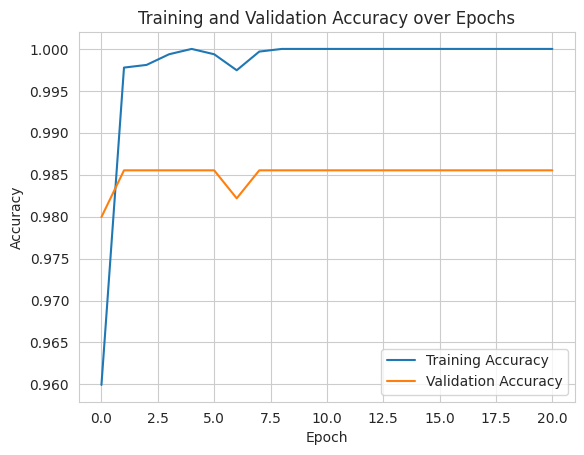

Max validation accuracy for this model: 0.9855234026908875
Validation metrics -> Precision: 0.9790, Recall: 1.0000, F1: 0.9894, AUC: 0.9603
Layer sizes: 512 256 128 64 32 16 
Number of layers: 6
Starting position: 3
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9254 - loss: 0.2238 - val_accuracy: 0.9833 - val_loss: 0.1543
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0062 - val_accuracy: 0.9844 - val_loss: 0.2187
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0031 - val_accuracy: 0.9855 - val_loss: 0.2128
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0106 - val_accuracy: 0.9822 - val_loss: 0.2439
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9833 - val_loss: 0.3248
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9833 - val_loss: 0.3260
Epoch 7/100
99/99 ━━━

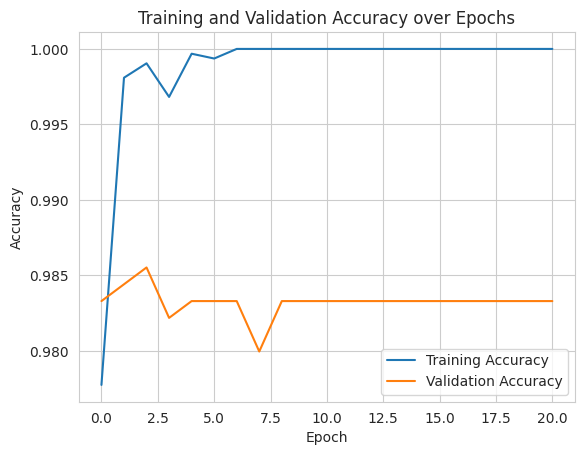

Max validation accuracy for this model: 0.9855234026908875
Validation metrics -> Precision: 0.9836, Recall: 0.9988, F1: 0.9911, AUC: 0.9552
Best validation accuracy: 0.9888641238212585
Best configuration: ('funnel', 4, 1)


In [26]:
best_val_acc = 0
best_config = None
results = []   # collect metrics for later analysis

# example: run the funnel models (you can also run try_model_pw2 similarly)
for layers in range(4, 7):                     # as in your original loop
    max_start = len(pw2) - layers
    for start in range(0, max_start + 1):
        model = try_model_pw2_funnel(layers, start)
        print("Number of layers:", layers)
        print("Starting position:", start)

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )

        history = model.fit(
            X_train, Y_train,
            epochs=100,
            validation_data=(X_valid, Y_valid),
            callbacks=[early_stopping],
            verbose=1
        )

        # plot accuracy history
        plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
        plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
        plt.title('Training and Validation Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

        val_acc = max(history.history.get('val_accuracy', [0]))
        print("Max validation accuracy for this model:", val_acc)

        # --- compute validation metrics ---
        # funnel model outputs 2-class softmax -> get class probs and predicted labels
        y_prob_all = model.predict(X_valid, verbose=0)    # shape (n_samples, 2)
        if y_prob_all.ndim == 2 and y_prob_all.shape[1] == 2:
            y_prob_pos = y_prob_all[:, 1]                # positive-class probability
            y_pred = np.argmax(y_prob_all, axis=1)
        else:
            # fallback (shouldn't happen for funnel): treat as single-probability
            y_prob_pos = y_prob_all.ravel()
            y_pred = (y_prob_pos >= 0.3).astype(int)

        prec = precision_score(Y_valid, y_pred, zero_division=0)
        rec  = recall_score   (Y_valid, y_pred, zero_division=0)
        f1   = f1_score       (Y_valid, y_pred, zero_division=0)
        try:
            auc = roc_auc_score(Y_valid, y_prob_pos)
        except ValueError:
            auc = float('nan')

        print(f"Validation metrics -> Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

        results.append({
            'type': 'funnel',
            'layers': layers,
            'start': start,
            'val_acc': val_acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'auc': auc
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = ('funnel', layers, start)

print("Best validation accuracy:", best_val_acc)
print("Best configuration:", best_config)


In [27]:
import numpy as np, pandas as pd, time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow import keras

class SklearnMetricsCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, train_data=None, threshold=0.2, train_sample_size=None):
        """
        validation_data: (X_val, y_val)
        train_data:      (X_train, y_train) or None
        threshold:       decision threshold for binary preds
        train_sample_size: if not None and less than len(X_train), sample this many rows each epoch
        """
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.train = train_data
        self.threshold = threshold
        self.train_sample_size = train_sample_size

        # store series if you want direct access after training
        self.train_precisions = []
        self.train_recalls = []
        self.train_f1s = []
        self.train_aucs = []

        self.val_precisions = []
        self.val_recalls = []
        self.val_f1s = []
        self.val_aucs = []

    def _maybe_sample(self, X, y):
        if self.train_sample_size is None:
            return X, y
        n = len(y)
        k = int(self.train_sample_size)
        if k >= n:
            return X, y
        idx = np.random.choice(n, size=k, replace=False)
        # handle numpy arrays and pandas DataFrames similarly using take
        try:
            return X[idx], y[idx]
        except Exception:
            # fallback for pandas: use iloc
            return X.iloc[idx], y.iloc[idx]

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # --- validation metrics ---
        y_val_prob = self.model.predict(self.X_val, verbose=0).ravel()
        y_val_pred = (y_val_prob >= self.threshold).astype(int)

        prec_v = precision_score(self.y_val, y_val_pred, zero_division=0)
        rec_v  = recall_score(self.y_val, y_val_pred, zero_division=0)
        f1_v   = f1_score(self.y_val, y_val_pred, zero_division=0)
        try:
            auc_v = roc_auc_score(self.y_val, y_val_prob)
        except ValueError:
            auc_v = float('nan')

        self.val_precisions.append(prec_v)
        self.val_recalls.append(rec_v)
        self.val_f1s.append(f1_v)
        self.val_aucs.append(auc_v)

        logs['val_precision_sklearn'] = prec_v
        logs['val_recall_sklearn']    = rec_v
        logs['val_f1_sklearn']        = f1_v
        logs['val_auc_sklearn']       = auc_v

        # --- training metrics (optional) ---
        if self.train is not None:
            X_train, y_train = self.train
            Xs, ys = self._maybe_sample(X_train, y_train)

            y_tr_prob = self.model.predict(Xs, verbose=0).ravel()
            y_tr_pred = (y_tr_prob >= self.threshold).astype(int)

            prec_t = precision_score(ys, y_tr_pred, zero_division=0)
            rec_t  = recall_score(ys, y_tr_pred, zero_division=0)
            f1_t   = f1_score(ys, y_tr_pred, zero_division=0)
            try:
                auc_t = roc_auc_score(ys, y_tr_prob)
            except ValueError:
                auc_t = float('nan')

            self.train_precisions.append(prec_t)
            self.train_recalls.append(rec_t)
            self.train_f1s.append(f1_t)
            self.train_aucs.append(auc_t)

            logs['train_precision_sklearn'] = prec_t
            logs['train_recall_sklearn']    = rec_t
            logs['train_f1_sklearn']        = f1_t
            logs['train_auc_sklearn']       = auc_t

# ---------------------------
# Usage (example)
# ---------------------------

# build & compile model as before
metrics = [
    keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.3),
    keras.metrics.Precision(name='precision', thresholds=[0.3]),
    keras.metrics.Recall(name='recall', thresholds=[0.3]),
    keras.metrics.AUC(name='auc')
]

model = try_model(6, 60)
model.compile(optimizer=keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=metrics)

# callbacks: checkpoint + early stop + our sklearn callback (now with train_data)
checkpoint_path = "best_val_acc_weights.weights.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# If your training set is very large and you want to speed up per-epoch scoring,
# pass train_sample_size (e.g. 5000). Otherwise leave it None to evaluate on full train set.
sklearn_cb = SklearnMetricsCallback(
    validation_data=(X_valid, Y_valid),
    train_data=(X_train, Y_train),
    threshold=0.3,
    train_sample_size=None  # or an int like 5000 to sample each epoch
)

history = model.fit(
    X_train, Y_train,
    epochs=100,
    validation_data=(X_valid, Y_valid),
    callbacks=[checkpoint_cb, earlystop_cb, sklearn_cb]
)

# ---------------------------
# Plotting train + val curves
# ---------------------------
hist = history.history

def plot_train_val(metric_train_key, metric_val_key, title, ylabel=''):
    plt.figure(figsize=(8,4))
    if metric_train_key in hist:
        plt.plot(hist[metric_train_key], label=f'train_{ylabel or metric_train_key}')
    else:
        print(f"Warning: {metric_train_key} not found in history.")
    if metric_val_key in hist:
        plt.plot(hist[metric_val_key], label=f'val_{ylabel or metric_val_key}')
    else:
        print(f"Warning: {metric_val_key} not found in history.")
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.ylim(0, 1.02)
    plt.grid(True)
    plt.legend()
    plt.show()


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9375 - auc: 0.8214 - loss: 0.5655 - precision: 0.9371 - recall: 0.9997
Epoch 1: val_accuracy improved from -inf to 0.98107, saving model to best_val_acc_weights.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9377 - auc: 0.8228 - loss: 0.5637 - precision: 0.9374 - recall: 0.9997 - val_accuracy: 0.9811 - val_auc: 0.9809 - val_loss: 0.2673 - val_precision: 0.9813 - val_recall: 0.9988 - val_precision_sklearn: 0.9813 - val_recall_sklearn: 0.9988 - val_f1_sklearn: 0.9900 - val_auc_sklearn: 0.9851 - train_precision_sklearn: 0.9973 - train_recall_sklearn: 0.9976 - train_f1_sklearn: 0.9974 - train_auc_sklearn: 0.9995
Epoch 2/100
80/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9943 - auc: 0.9993 - loss: 0.2070 - precision: 0.9943 - recall: 0.9995
Epoch 2: val_accuracy improved from 0.98107 to 0.98552, saving model to best_val_acc_weights.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9946 - 

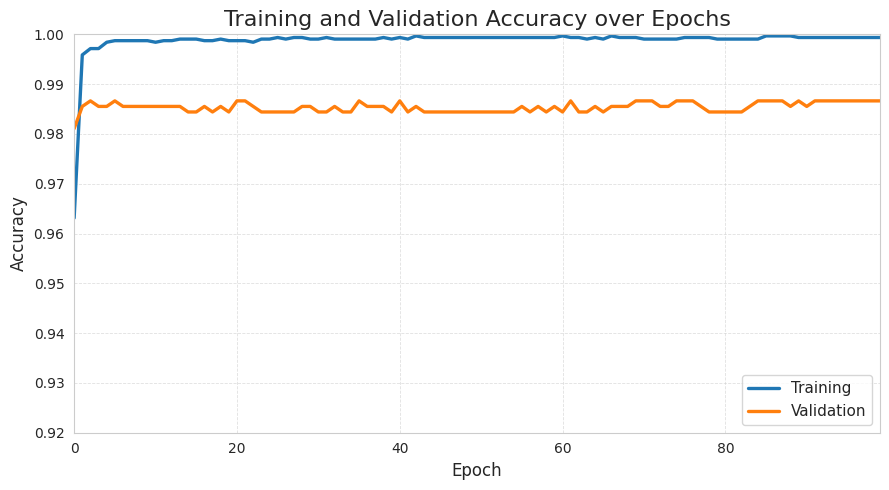

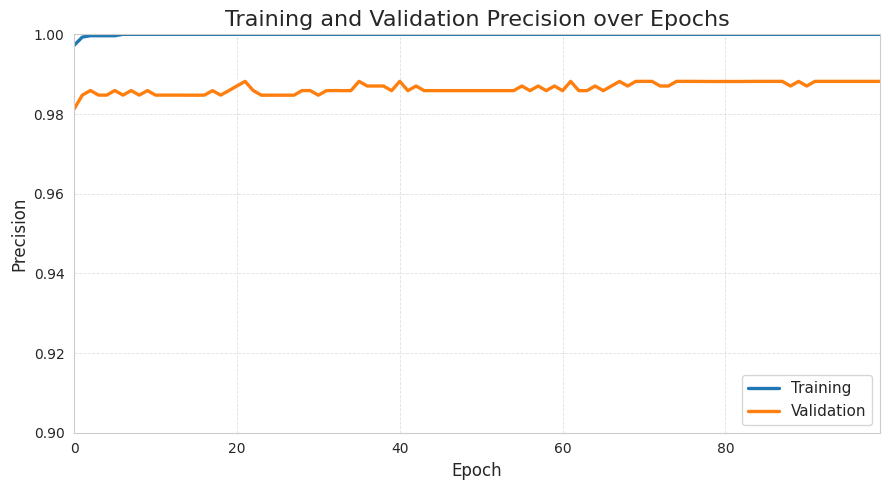

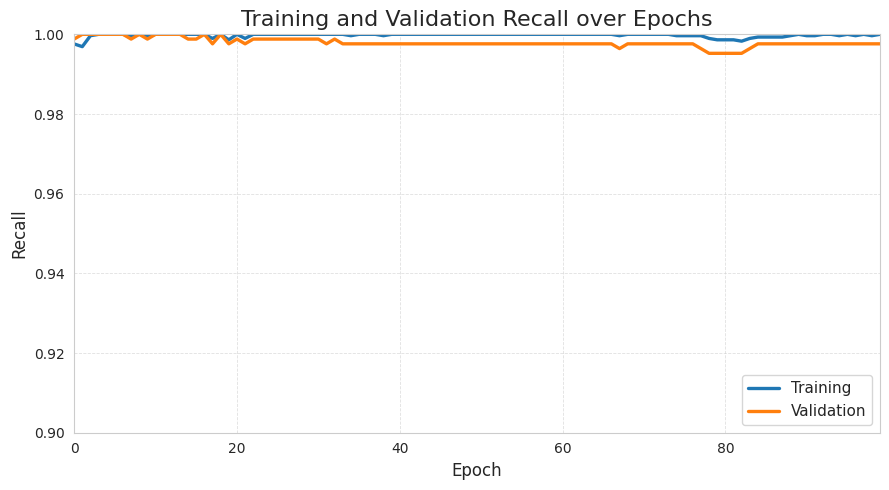

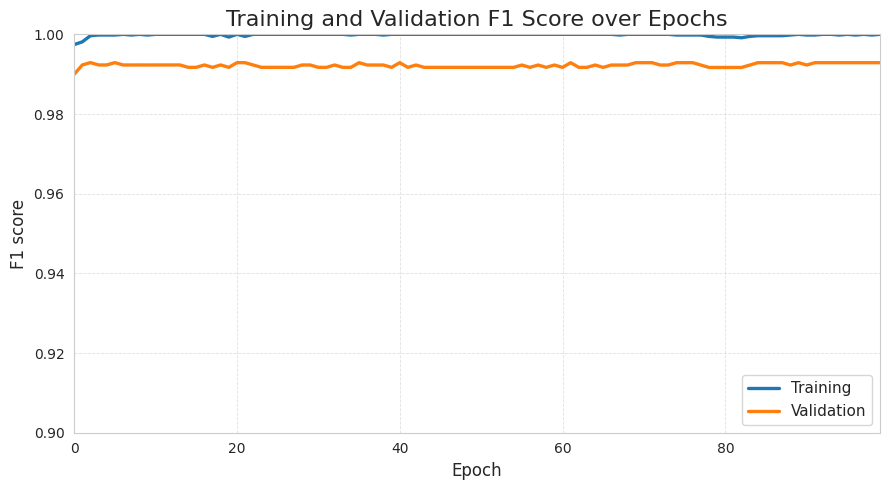

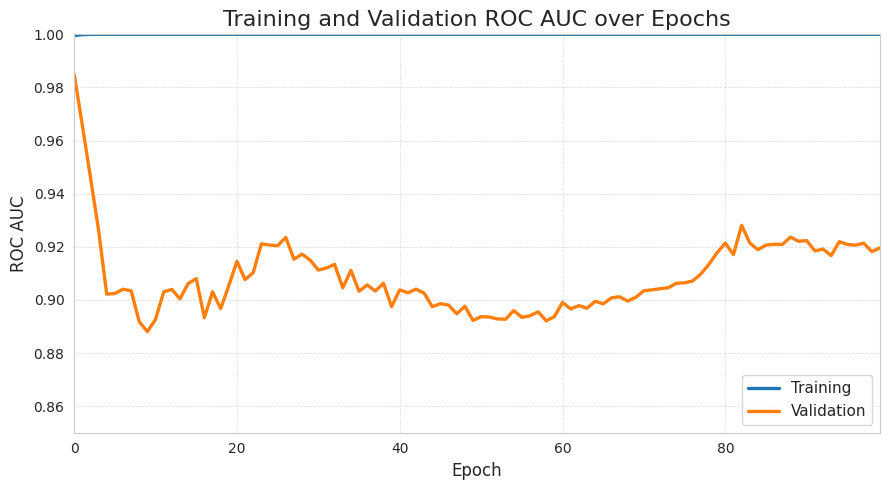

In [29]:
import matplotlib.pyplot as plt
import numpy as np

hist = history.history  # History returned by model.fit()

def find_key(hist, candidates):
    """Return first key from candidates that exists in hist, else None."""
    for k in candidates:
        if k in hist:
            return k
    return None

def plot_train_val_from_options(train_options, val_options, title, ylabel, ylim=(0,1.02)):
    train_key = find_key(hist, train_options)
    val_key   = find_key(hist, val_options)

    if train_key is None and val_key is None:
        print(f"Skipping {title}: no keys found ({train_options} / {val_options})")
        return

    epochs = np.arange(len(hist[val_key] if val_key is not None else hist[train_key]))
    plt.figure(figsize=(9,5))
    if train_key is not None:
        plt.plot(epochs, hist[train_key], label=f'Training', linewidth=2.4)
    if val_key is not None:
        plt.plot(epochs, hist[val_key], label=f'Validation', linewidth=2.4)
    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.ylim(*ylim)
    plt.xlim(0, max(0, epochs[-1]))
    plt.grid(axis='both', linestyle='--', linewidth=0.6, alpha=0.6)
    plt.legend(loc='lower right', fontsize=11, frameon=True)
    plt.tight_layout()
    plt.show()

# Accuracy (TF metric keys)
plot_train_val_from_options(
    train_options=['accuracy', 'acc', 'train_accuracy'],
    val_options=['val_accuracy'],
    title='Training and Validation Accuracy over Epochs',
    ylabel='Accuracy',
    ylim=(0.92, 1)  # adjust to focus the range similar to your sample image
)

# Precision (try sklearn callback keys first, then TF keys)
plot_train_val_from_options(
    train_options=['train_precision_sklearn', 'precision', 'train_precision'],
    val_options  =['val_precision_sklearn', 'val_precision'],
    title='Training and Validation Precision over Epochs',
    ylabel='Precision',
    ylim=(0.90, 1) 
)

# Recall
plot_train_val_from_options(
    train_options=['train_recall_sklearn', 'recall', 'train_recall'],
    val_options  =['val_recall_sklearn', 'val_recall'],
    title='Training and Validation Recall over Epochs',
    ylabel='Recall',
    ylim=(0.90, 1) 
)

# F1 (TF does not provide F1 by default; we expect sklearn-callback keys)
plot_train_val_from_options(
    train_options=['train_f1_sklearn', 'train_f1'],
    val_options  =['val_f1_sklearn', 'val_f1'],
    title='Training and Validation F1 Score over Epochs',
    ylabel='F1 score',
    ylim=(0.90, 1) 
)

# ROC AUC (try sklearn-callback keys, then TF AUC)
plot_train_val_from_options(
    train_options=['train_auc_sklearn', 'auc', 'train_auc'],
    val_options  =['val_auc_sklearn', 'val_auc'],
    title='Training and Validation ROC AUC over Epochs',
    ylabel='ROC AUC',
    ylim=(0.85, 1) 
)


In [30]:
# === Train + Save best model for try_model(6, 60) ===
# Drop this into the notebook where try_model, X, Y, df_known, df_unknown, num_features exist.
# Adjust paths/variables only if your notebook uses different names.

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1) Parameters
THRESH = 0.3
BEST_PATH = "best_model.h5"
PATIENCE = 100          # early stopping patience
EPOCHS = 100           # set to the value you used previously (100 in your paper)
BATCH = 32

# 2) Prepare training/validation sets
# If you already have a chronological split X_train, X_val etc. in your notebook use them.
if 'X_train' in globals() and 'X_valid' in globals() and 'Y_train' in globals() and 'Y_valid' in globals():
    Xt, Xv, yt, yv = X_train, X_valid, Y_train, Y_valid
else:
    # fallback: use X and Y defined in the notebook (X = features, Y = labels)
    if 'X' not in globals() or 'Y' not in globals():
        raise RuntimeError("No X/Y found. Make sure you have feature matrix X and label vector Y in the notebook.")
    # recommended: use stratified split to preserve class balance
    Xt, Xv, yt, yv = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# 3) Build model using your try_model function
# try_model should return a compiled keras model ready to fit
model = try_model(6, 60)   # using your function as requested

# 4) Callbacks to save best model and stop early
# Monitor validation accuracy (you can switch to 'val_loss' or a custom metric if desired)
checkpoint = ModelCheckpoint(
    BEST_PATH,
    monitor='val_accuracy',  # or 'val_loss' if you prefer
    verbose=1,
    save_best_only=True,
    save_weights_only=False, # saves whole model (architecture + weights)
    mode='max'
)
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)

# 5) Fit model
history = model.fit(
    Xt, yt,
    validation_data=(Xv, yv),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[checkpoint, early_stop],
    verbose=2
)

# After fit, best model saved to BEST_PATH (best_model.h5) according to val_accuracy

# 6) Load best model and evaluate on validation/test set
best = load_model(BEST_PATH)
y_prob_val = best.predict(Xv).reshape(-1)
y_pred_val = (y_prob_val >= THRESH).astype(int)

print("Validation metrics (using saved best model + threshold {:.2f}):".format(THRESH))
print("Acc:", accuracy_score(yv, y_pred_val))
print("Prec:", precision_score(yv, y_pred_val, zero_division=0))
print("Rec:", recall_score(yv, y_pred_val, zero_division=0))
print("F1:", f1_score(yv, y_pred_val, zero_division=0))


Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.98218, saving model to best_model.h5
99/99 - 9s - 88ms/step - accuracy: 0.9596 - auc: 0.9509 - loss: 0.3958 - precision: 0.9603 - recall: 0.9976 - val_accuracy: 0.9822 - val_auc: 0.9644 - val_loss: 0.2756 - val_precision: 0.9824 - val_recall: 0.9988
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.98218
99/99 - 0s - 4ms/step - accuracy: 0.9962 - auc: 0.9995 - loss: 0.1755 - precision: 0.9973 - recall: 0.9986 - val_accuracy: 0.9822 - val_auc: 0.9473 - val_loss: 0.2283 - val_precision: 0.9824 - val_recall: 0.9988
Epoch 3/100

Epoch 3: val_accuracy improved from 0.98218 to 0.98552, saving model to best_model.h5
99/99 - 0s - 4ms/step - accuracy: 0.9984 - auc: 0.9999 - loss: 0.1240 - precision: 0.9990 - recall: 0.9993 - val_accuracy: 0.9855 - val_auc: 0.9221 - val_loss: 0.2196 - val_precision: 0.9847 - val_recall: 1.0000
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.98552
99/99 - 0s - 4ms/step - accuracy: 0.9984

InvalidArgumentError: Graph execution error:

Detected at node sequential_32_1/dense_223_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [32,17], In[1]: [13,60]

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 211, in start
File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "/tmp/ipykernel_36/4280663994.py", line 86, in <cell line: 0>
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 213, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py", line 144, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 3815, in matmul
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/numpy.py", line 501, in matmul

	 [[{{node sequential_32_1/dense_223_1/MatMul}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_1898867[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_1898898]

In [36]:
# save_as: /mnt/data/run_predictions_from_best_model.py
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Paths (assumes these files are in /mnt/data)
DATA_PATH = "/kaggle/input/floodprediction/FloodPrediction.csv"
MODEL_PATH = "best_model.h5"   # upload this file here
OUTPUT_CSV = "predictions_all_splits.csv"

THRESH = 0.3  # threshold used in your notebook

def load_data(path):
    df = pd.read_csv(path)
    return df

def preprocess_and_split(df):
    # Detect label column and numeric features same as in notebook
    label_col = 'Flood'
    # Rows with known labels vs unknown labels (notna)
    mask_known = df[label_col].notna()
    df_known = df[mask_known].copy()
    df_unknown = df[~mask_known].copy()

    # create date from Year and Month (same logic)
    if 'Year' in df_known.columns and 'Month' in df_known.columns:
        df_known['date'] = pd.to_datetime(df_known['Year'].astype(str) + '-' +
                                          df_known['Month'].astype(str).str.zfill(2) + '-01')
    else:
        # if Year/Month missing, create a dummy increasing date from index
        df_known = df_known.reset_index(drop=True)
        df_known['date'] = pd.date_range(start='2000-01-01', periods=len(df_known), freq='M')

    # drop columns as in your notebook if they exist
    cols_to_drop = [c for c in ['Sl', 'Station_Names', 'Station_Number', 'Year', 'Month'] if c in df_known.columns]
    df_known = df_known.drop(columns=cols_to_drop)

    # sort chronologically and reset index
    df_known = df_known.sort_values('date').reset_index(drop=True)

    # define X and Y (remove date and Flood from features)
    Y = df_known[label_col].astype(float).reset_index(drop=True)
    drop_cols = [c for c in ['date', label_col] if c in df_known.columns]
    X = df_known.drop(columns=drop_cols)

    # numeric features only (the notebook used numeric features)
    num_features = X.select_dtypes(include=[np.number]).columns.tolist()
    X_num = X[num_features].copy().reset_index(drop=True)

    # contiguous chronological split indices
    n = len(df_known)
    train_end = int(n * 0.7)
    val_end = int(n * 0.9)

    # build splits (use iloc on the numeric dataframe)
    X_train = X_num.iloc[:train_end].values
    Y_train = Y.iloc[:train_end].values

    X_valid = X_num.iloc[train_end:val_end].values
    Y_valid = Y.iloc[train_end:val_end].values

    X_test  = X_num.iloc[val_end:].values
    Y_test  = Y.iloc[val_end:].values

    # Keep dataframes for reconstructing CSV outputs and mapping indexes
    df_known_for_output = df_known.copy().reset_index(drop=True)
    df_unknown_for_output = df_unknown.copy().reset_index(drop=True)

    return {
        "X_train": X_train, "Y_train": Y_train,
        "X_valid": X_valid, "Y_valid": Y_valid,
        "X_test": X_test,   "Y_test": Y_test,
        "num_features": num_features,
        "df_known": df_known_for_output,
        "df_unknown": df_unknown_for_output,
        "train_end": train_end, "val_end": val_end
    }

def scale_data(X_train, X_valid, X_test):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_valid_s = scaler.transform(X_valid)
    X_test_s  = scaler.transform(X_test)
    return X_train_s, X_valid_s, X_test_s, scaler

def predict_and_save(model_path, data_info, output_csv, thresh=THRESH):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}. Please upload best_model.h5 to /mnt/data")

    model = load_model(model_path)
    X_train = data_info["X_train"]
    X_valid = data_info["X_valid"]
    X_test  = data_info["X_test"]

    # scale
    X_train_s, X_valid_s, X_test_s, scaler = scale_data(X_train, X_valid, X_test)

    # predict probabilities (model outputs probability via sigmoid)
    p_train = model.predict(X_train_s, batch_size=64).reshape(-1)
    p_valid = model.predict(X_valid_s, batch_size=64).reshape(-1)
    p_test  = model.predict(X_test_s, batch_size=64).reshape(-1)

    # threshold to get binary predictions
    yhat_train = (p_train >= thresh).astype(int)
    yhat_valid = (p_valid >= thresh).astype(int)
    yhat_test  = (p_test  >= thresh).astype(int)

    # Build output DataFrame for known rows (train/valid/test)
    df_known = data_info["df_known"].copy()
    n_train = len(p_train)
    n_valid = len(p_valid)
    # indices in df_known are 0..n-1 after reset_index earlier
    df_known = df_known.reset_index(drop=True)
    df_known_output = df_known.copy()
    df_known_output['split'] = ''
    df_known_output.loc[:n_train-1, 'split'] = 'train'
    df_known_output.loc[n_train:n_train+n_valid-1, 'split'] = 'validation'
    df_known_output.loc[n_train+n_valid:, 'split'] = 'test'
    # store true label where available
    df_known_output['true_Flood'] = df_known_output['Flood'].astype(float)
    # attach probabilities and predictions
    probs = np.concatenate([p_train, p_valid, p_test], axis=0)
    preds = np.concatenate([yhat_train, yhat_valid, yhat_test], axis=0)
    df_known_output['pred_prob'] = probs
    df_known_output['pred_label'] = preds

    # For rows with unknown label, prepare predictions (use numeric features consistent with df_known's columns)
    df_unknown = data_info["df_unknown"].copy()
    if not df_unknown.empty:
        # drop same columns as we dropped from known
        cols_to_drop = [c for c in ['Sl', 'Station_Names', 'Station_Number', 'Year', 'Month', 'date'] if c in df_unknown.columns]
        df_unknown = df_unknown.drop(columns=[c for c in cols_to_drop if c in df_unknown.columns], errors='ignore')
        # pick numeric features in the same order (num_features)
        X_unknown_num = df_unknown[data_info['num_features']].copy()
        # Fill NaN numeric values with 0 or column mean; we will use column means from X_train
        X_unknown_num = X_unknown_num.fillna(0).values
        # scale using scaler
        X_unknown_s = scaler.transform(X_unknown_num)
        p_unknown = model.predict(X_unknown_s, batch_size=64).reshape(-1)
        y_unknown = (p_unknown >= thresh).astype(int)
        df_unknown_output = data_info["df_unknown"].copy().reset_index(drop=True)
        df_unknown_output['split'] = 'unknown_label'
        df_unknown_output['true_Flood'] = np.nan
        df_unknown_output['pred_prob'] = p_unknown
        df_unknown_output['pred_label'] = y_unknown
    else:
        df_unknown_output = pd.DataFrame(columns=list(df_known_output.columns))

    # Compose final CSV (known then unknown)
    cols_to_keep = ['split', 'true_Flood', 'pred_prob', 'pred_label']
    # keep original columns too to allow traceability
    out_known = pd.concat([df_known_output.reset_index(drop=True)], axis=1)
    out_unknown = df_unknown_output.reset_index(drop=True) if not df_unknown_output.empty else None

    # Write to CSV
    if out_unknown is not None:
        final_df = pd.concat([out_known, out_unknown], axis=0, ignore_index=True, sort=False)
    else:
        final_df = out_known

    final_df.to_csv(output_csv, index=False)
    return output_csv, final_df

if __name__ == "__main__":
    print("Loading data from:", DATA_PATH)
    df = load_data(DATA_PATH)
    print("Preprocessing and splitting...")
    data_info = preprocess_and_split(df)
    print("Found numeric features:", data_info['num_features'])
    print("Train/Val/Test sizes:", data_info['X_train'].shape[0], data_info['X_valid'].shape[0], data_info['X_test'].shape[0])

    print("Making predictions using model:", MODEL_PATH)
    out_csv, out_df = predict_and_save(MODEL_PATH, data_info, OUTPUT_CSV, thresh=THRESH)
    print("Wrote predictions to:", out_csv)
    print(out_df.head(10))


Loading data from: /kaggle/input/floodprediction/FloodPrediction.csv
Preprocessing and splitting...
Found numeric features: ['Max Temperature', 'Min Temperature', 'Rainfall', 'Relative Humidity', 'Wind Speed', 'Cloud Coverage', 'Bright Sunshine', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Altitude', 'Period']
Train/Val/Test sizes: 3145 898 450
Making predictions using model: best_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Wrote predictions to: predictions_all_splits.csv
   Max Temperature  Min Temperature    Rainfall  Relative Humidity  \
0             36.8             23.5   244.00000            82.0000   
1             34.3             23.6   537.00000            81.0000   
2             34.3             25.4   619.00000            88.0000   
3             35.3             25.4   285.00000            86.0000   
4             33.9             25.3  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [ ]:
model, fit_times = fit_with_timing(try_model(6, 60), X_train, Y_train, verbose=True)
pred_times = predict_with_timing(model, X_test, repeat=3, method="predict", verbose=True)


In [ ]:
cv_summary = evaluate_cv_keras(lambda: try_model(6, 60), X, Y, cv=5, epochs=30, batch_size=32, verbose=2)
print(cv_summary)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier(n_estimators=100, random_state=0)
lr = LogisticRegression(max_iter=2000)

res = paired_model_tests(rf, lr, X, Y, cv=5, metric="accuracy", n_permutations=2000, n_bootstrap=2000, random_state=42)
print("mean diff (rf - lr):", res["mean_diff"])
print("paired t-test:", res["t_test"])
print("permutation p-value:", res["permutation_pvalue"])
print("bootstrap 95% CI:", res["bootstrap_ci_95"])
print("cohen's d:", res["cohens_d"])
print("per-fold scores rf:", res["scores1"])
print("per-fold scores lr:", res["scores2"])

In [ ]:
y_valid_probs = model.predict(X_valid)

threshold = 0.3
y_valid_pred = (y_valid_probs >= threshold).astype(int)



f1   = f1_score(Y_valid, y_valid_pred)
prec = precision_score(Y_valid, y_valid_pred)
rec  = recall_score(Y_valid, y_valid_pred)
auc  = roc_auc_score(Y_valid, y_valid_probs)

acc  = accuracy_score(Y_valid, y_valid_pred)

print(f"Threshold = {threshold}")
print(f"Validation Accuracy:  {acc:.4f}")
print(f"Precision:            {prec:.4f}")
print(f"Recall:               {rec:.4f}")
print(f"F1 Score:             {f1:.4f}")
print(f"ROC AUC Score:        {auc:.4f}")

In [ ]:
import time
import numpy as np
import os
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# -------------------------
# Updated callback
# -------------------------
class SklearnMetricsCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, train_data=None, threshold=0.2,
                 train_sample_size=None, predict_batch_size=None):
        """
        predict_batch_size: batch size used for model.predict calls inside the callback.
                            Set it equal to the batch_size used in model.fit to ensure
                            comparable timings and identical batching behavior.
        """
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.train = train_data
        self.threshold = threshold
        self.train_sample_size = train_sample_size
        self.predict_batch_size = predict_batch_size

        # store series if you want direct access after training
        self.train_precisions = []
        self.train_recalls = []
        self.train_f1s = []
        self.train_aucs = []

        self.val_precisions = []
        self.val_recalls = []
        self.val_f1s = []
        self.val_aucs = []

    def _maybe_sample(self, X, y):
        if self.train_sample_size is None:
            return X, y
        n = len(y)
        k = int(self.train_sample_size)
        if k >= n:
            return X, y
        idx = np.random.choice(n, size=k, replace=False)
        try:
            return X[idx], y[idx]
        except Exception:
            return X.iloc[idx], y.iloc[idx]

    def _predict(self, X):
        # centralize predict call so batch_size control is consistent
        kwargs = {}
        if self.predict_batch_size is not None:
            kwargs['batch_size'] = self.predict_batch_size
        return self.model.predict(X, verbose=0, **kwargs).ravel()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # --- validation metrics ---
        y_val_prob = self._predict(self.X_val)
        y_val_pred = (y_val_prob >= self.threshold).astype(int)

        prec_v = precision_score(self.y_val, y_val_pred, zero_division=0)
        rec_v  = recall_score(self.y_val, y_val_pred, zero_division=0)
        f1_v   = f1_score(self.y_val, y_val_pred, zero_division=0)
        try:
            auc_v = roc_auc_score(self.y_val, y_val_prob)
        except ValueError:
            auc_v = float('nan')

        self.val_precisions.append(prec_v)
        self.val_recalls.append(rec_v)
        self.val_f1s.append(f1_v)
        self.val_aucs.append(auc_v)

        logs['val_precision_sklearn'] = prec_v
        logs['val_recall_sklearn']    = rec_v
        logs['val_f1_sklearn']        = f1_v
        logs['val_auc_sklearn']       = auc_v

        # --- training metrics (optional) ---
        if self.train is not None:
            X_train, y_train = self.train
            Xs, ys = self._maybe_sample(X_train, y_train)

            y_tr_prob = self._predict(Xs)
            y_tr_pred = (y_tr_prob >= self.threshold).astype(int)

            prec_t = precision_score(ys, y_tr_pred, zero_division=0)
            rec_t  = recall_score(ys, y_tr_pred, zero_division=0)
            f1_t   = f1_score(ys, y_tr_pred, zero_division=0)
            try:
                auc_t = roc_auc_score(ys, y_tr_prob)
            except ValueError:
                auc_t = float('nan')

            self.train_precisions.append(prec_t)
            self.train_recalls.append(rec_t)
            self.train_f1s.append(f1_t)
            self.train_aucs.append(auc_t)

            logs['train_precision_sklearn'] = prec_t
            logs['train_recall_sklearn']    = rec_t
            logs['train_f1_sklearn']        = f1_t
            logs['train_auc_sklearn']       = auc_t

# -------------------------
# Timing helpers
# -------------------------
def fit_with_timing(model, X, y, **fit_kwargs):
    """
    Fit model and measure wall-clock and CPU time. Returns:
      history, timing_dict
    timing_dict contains: wall_time_s, cpu_time_s
    """
    # Ensure reproducible-ish time measurement
    t0_wall = time.perf_counter()
    t0_cpu = time.process_time()

    history = model.fit(X, y, **fit_kwargs)

    t1_wall = time.perf_counter()
    t1_cpu = time.process_time()

    timing = {
        'fit_wall_time_s': t1_wall - t0_wall,
        'fit_cpu_time_s': t1_cpu - t0_cpu
    }
    return history, timing

def predict_with_timing(model, X, batch_size=None, repeats=10, warmup=2):
    """
    Measure inference time using model.predict with the given batch_size.
    Returns a dictionary with:
      - mean_run_s: mean seconds per run (predicting on full X)
      - per_sample_ms: mean milliseconds per sample (amortized across batch)
      - throughput_samples_s: mean throughput (samples/sec)
      - latencies: list of run times (s)
      - p50/p95/p99 (s)
    Important: set batch_size equal to the batch_size used in training to get comparable timings.
    """
    # Warm-up runs (not timed)
    for _ in range(warmup):
        model.predict(X, batch_size=batch_size, verbose=0)

    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        model.predict(X, batch_size=batch_size, verbose=0)
        t1 = time.perf_counter()
        times.append(t1 - t0)

    times = np.array(times)
    mean_run = float(times.mean())
    per_sample_s = mean_run / len(X)
    throughput = len(X) / mean_run if mean_run > 0 else float('inf')

    stats = {
        'mean_run_s': mean_run,
        'per_sample_ms': per_sample_s * 1000.0,
        'throughput_samples_s': throughput,
        'run_times_s': times.tolist(),
        'p50_s': float(np.percentile(times, 50)),
        'p95_s': float(np.percentile(times, 95)),
        'p99_s': float(np.percentile(times, 99)),
    }
    return stats

# -------------------------
# Example usage (replace try_model/X_train/etc with your code)
# -------------------------
# Build & compile model (example)
metrics = [
    keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.3),
    keras.metrics.Precision(name='precision', thresholds=[0.3]),
    keras.metrics.Recall(name='recall', thresholds=[0.3]),
    keras.metrics.AUC(name='auc')
]

model = try_model(6, 60)   # <-- your model builder
model.compile(optimizer=keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=metrics)

# Prepare callbacks (use same batch_size below)
batch_size = 32   # <-- choose the same batch size you will use for training and inference timing

checkpoint_path = "best_val_acc_weights.weights.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Use our callback and pass predict_batch_size equal to training batch size
sklearn_cb = SklearnMetricsCallback(
    validation_data=(X_valid, Y_valid),
    train_data=(X_train, Y_train),
    threshold=0.3,
    train_sample_size=None,
    predict_batch_size=batch_size
)

# Fit with timing wrapper
history, fit_timing = fit_with_timing(
    model,
    X_train, Y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_valid, Y_valid),
    callbacks=[checkpoint_cb, earlystop_cb, sklearn_cb],
    verbose=1
)

print("Fit wall time: {:.4f}s, CPU time: {:.4f}s".format(
    fit_timing['fit_wall_time_s'], fit_timing['fit_cpu_time_s']))

# After training, measure inference using the same batch_size to be comparable
inference_stats = predict_with_timing(model, X_test, batch_size=batch_size, repeats=10, warmup=2)
print("Inference mean run (s):", inference_stats['mean_run_s'])
print("Per-sample (ms):", inference_stats['per_sample_ms'])
print("Throughput (samples/s):", inference_stats['throughput_samples_s'])
print("Latency percentiles (s): p50={:.4f}, p95={:.4f}, p99={:.4f}".format(
    inference_stats['p50_s'], inference_stats['p95_s'], inference_stats['p99_s']))

# -------------------------
# Notes / tips
# -------------------------
# 1) Use the SAME batch_size for model.fit and predict_with_timing to make timings comparable.
# 2) If you used data generators / tf.data pipelines during training, measure inference by
#    running predictions through the same pipeline to include preprocessing cost.
# 3) For more reproducible CPU timing, consider fixing intra/inter-op thread counts:
#      import tensorflow as tf
#      tf.config.threading.set_intra_op_parallelism_threads(1)
#      tf.config.threading.set_inter_op_parallelism_threads(1)
#    (but document this clearly in Methods if you change threading.)
# 4) Always run a few warm-up predictions (the helper does this) before measuring.


In [ ]:
X_sample = X_train[:min(len(X_train), 200)]
shap_res = shap_explain(model, X_sample, feature_names=list(X.columns), nsamples=200)
if shap_res["method"] == "shap":
    print(shap_res["result"].head(20))
else:
    print("Used permutation fallback; call permutation_importance_any directly with y to get results.")


In [ ]:
# ---------- Repeated 5x5 CV comparison (paste into your notebook) ----------
# Requires: X (samples x features), Y (labels), try_model(layers, neurons) defined in notebook.
# This cell runs RepeatedStratifiedKFold(5, repeats=5) and computes paired stats.

import numpy as np
import random
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats
import math
import tqdm

# Parameters (tweak if needed)
N_SPLITS = 5
N_REPEATS = 1
RANDOM_SEED = 42
NN_EPOCHS = 100       # set to the same number you used in earlier CV if desired
NN_BATCH = 32
PERMUTATIONS = 5000  # permutation test resamples (5000 is a reasonable tradeoff)
BOOTSTRAP_REPS = 5000

# make sure X and Y are numpy arrays
X_arr = np.asarray(X)    # X defined in your notebook
y_arr = np.asarray(Y)    # Y defined in your notebook

rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_SEED)

scores_nn = []
scores_rf = []
split_idx = 0

# Use the same global-name X_train that try_model expects (try_model references X_train.shape[1])
for train_idx, test_idx in rskf.split(X_arr, y_arr):
    # set seeds for reproducibility inside each fold
    np.random.seed(RANDOM_SEED + split_idx)
    random.seed(RANDOM_SEED + split_idx)
    try:
        import tensorflow as tf
        tf.random.set_seed(RANDOM_SEED + split_idx)
    except Exception:
        pass

    X_train_1, X_test_1 = X_arr[train_idx], X_arr[test_idx]
    y_train_1, y_test_1 = y_arr[train_idx], y_arr[test_idx]

    # Standardize features based on training fold
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_train_1)
    X_te_scaled = scaler.transform(X_test_1)

    # --- Logistic Regression (sklearn) ---
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr_scaled, y_train_1)
    y_pred_rf = rf.predict(X_te_scaled)
    acc_rf = accuracy_score(y_test_1, y_pred_rf)

    # --- Neural Network (Keras) ---
    # Place X_train into a global name in case your try_model uses X_train.shape[1]
    # (your try_model uses X_train.shape[1], so we set the same name here)
    X_train_1 = X_tr_scaled
    X_valid = X_te_scaled   # not used by builder but safe to set

    earlystop_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    # build a fresh model using your builder function
    model = try_model(6, 60)   # change args if you used a different best model
    # train: use early stopping or fixed epochs (match your paper's setup)
    model.fit(X_tr_scaled, y_train_1, epochs=NN_EPOCHS, batch_size=NN_BATCH, callbacks=[earlystop_cb], verbose=0)

    # predict probabilities and threshold at 0.3 (as in paper)
    y_prob = model.predict(X_te_scaled).ravel()
    y_pred_nn = (y_prob >= 0.5).astype(int)
    acc_nn = accuracy_score(y_test_1, y_pred_nn)

    scores_nn.append(acc_nn)
    scores_rf.append(acc_rf)

    split_idx += 1

scores_nn = np.array(scores_nn)
scores_rf = np.array(scores_rf)
diffs = scores_nn - scores_rf
n_pairs = len(diffs)

print("Paired folds:", n_pairs)
print("NN accuracies: ", np.round(scores_nn, 6))
print("RF accuracies: ", np.round(scores_rf, 6))
print("Mean diff (NN - RF):", diffs.mean(), "Std diff:", diffs.std(ddof=1))

# --- Paired t-test ---
t_stat, t_p = stats.ttest_rel(scores_nn, scores_rf, nan_policy='omit')
print("Paired t-test: t = %.4f, p = %.4f" % (t_stat, t_p))

# --- Wilcoxon signed-rank test (nonparametric) ---
try:
    w_stat, w_p = stats.wilcoxon(scores_nn, scores_rf)
    print("Wilcoxon signed-rank: stat = %.4f, p = %.4f" % (w_stat, w_p))
except Exception as e:
    print("Wilcoxon test failed:", e)
    w_p = None

# --- Permutation test (paired sign-flip) ---
# Null: no difference. For each permutation flip sign of diffs randomly.
obs_mean = diffs.mean()
rng = np.random.RandomState(RANDOM_SEED)
count = 0
for _ in range(PERMUTATIONS):
    signs = rng.choice([1, -1], size=n_pairs)
    perm_mean = (diffs * signs).mean()
    if abs(perm_mean) >= abs(obs_mean):
        count += 1
perm_p = (count + 1) / (PERMUTATIONS + 1)
print("Permutation sign-flip p-value (two-sided):", perm_p)

# --- Bootstrap 95% CI for mean difference ---
rng = np.random.RandomState(RANDOM_SEED + 1)
boot_means = []
for _ in range(BOOTSTRAP_REPS):
    idx = rng.randint(0, n_pairs, size=n_pairs)
    boot_means.append(diffs[idx].mean())
boot_means = np.array(boot_means)
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)
# f-string (recommended)
print(f"Bootstrap 95% CI for mean diff: ({ci_lower:.6f}, {ci_upper:.6f})")

# or .format()
print("Bootstrap 95% CI for mean diff: ({:.6f}, {:.6f})".format(ci_lower, ci_upper))

# or escape the percent if you want to keep % formatting (less clean)
print("Bootstrap 95%% CI for mean diff: (%.6f, %.6f)" % (ci_lower, ci_upper))


# --- Cohen's d (paired) ---
mean_diff = diffs.mean()
std_diff = diffs.std(ddof=1)
cohens_d = mean_diff / std_diff if std_diff != 0 else np.nan
print("Cohen's d (paired):", cohens_d)

# Collect results in a dict for convenience
cv_res = {
    "scores_nn": scores_nn,
    "scores_rf": scores_rf,
    "diffs": diffs,
    "mean_diff": mean_diff,
    "std_diff": std_diff,
    "t_test": {"statistic": float(t_stat), "pvalue": float(t_p)},
    "wilcoxon_p": float(w_p) if w_p is not None else None,
    "permutation_pvalue": float(perm_p),
    "bootstrap_ci_95": (float(ci_lower), float(ci_upper)),
    "cohens_d": float(cohens_d),
    "n_pairs": n_pairs
}

# print short summary
print("\nSummary:")
print(" mean diff: {:.6f}".format(mean_diff))
print(" 95% bootstrap CI: ({:.6f}, {:.6f})".format(ci_lower, ci_upper))
print(" paired t-test p:", t_p)
print(" wilcoxon p:", w_p)
print(" permutation p:", perm_p)
print(" cohen's d:", cohens_d)

# Optionally: save cv_res to file
import json
with open("cv_repeated_5x5_results.json", "w") as f:
    json.dump(cv_res, f, indent=2)

# ---------- End of cell ----------


In [ ]:
# ---------- Repeated 5x5 CV comparison (paste into your notebook) ----------
# Requires: X (samples x features), Y (labels), try_model(layers, neurons) defined in notebook.
# This cell runs RepeatedStratifiedKFold(5, repeats=5) and computes paired stats.

import numpy as np
import random
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats
import math
import tqdm

# Parameters (tweak if needed)
N_SPLITS = 5
N_REPEATS = 5
RANDOM_SEED = 42
NN_EPOCHS = 30       # set to the same number you used in earlier CV if desired
NN_BATCH = 32
PERMUTATIONS = 5000  # permutation test resamples (5000 is a reasonable tradeoff)
BOOTSTRAP_REPS = 5000

# make sure X and Y are numpy arrays
X_arr = np.asarray(X)    # X defined in your notebook
y_arr = np.asarray(Y)    # Y defined in your notebook

rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_SEED)

scores_nn = []
scores_lr = []
split_idx = 0

# Use the same global-name X_train that try_model expects (try_model references X_train.shape[1])
for train_idx, test_idx in rskf.split(X_arr, y_arr):
    # set seeds for reproducibility inside each fold
    np.random.seed(RANDOM_SEED + split_idx)
    random.seed(RANDOM_SEED + split_idx)
    try:
        import tensorflow as tf
        tf.random.set_seed(RANDOM_SEED + split_idx)
    except Exception:
        pass

    X_train_1, X_test_1 = X_arr[train_idx], X_arr[test_idx]
    y_train_1, y_test_1 = y_arr[train_idx], y_arr[test_idx]

    # Standardize features based on training fold
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_train_1)
    X_te_scaled = scaler.transform(X_test_1)

    # --- Logistic Regression (sklearn) ---
    lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED)
    lr.fit(X_tr_scaled, y_train_1)
    y_pred_lr = lr.predict(X_te_scaled)
    acc_lr = accuracy_score(y_test_1, y_pred_lr)

    # --- Neural Network (Keras) ---
    # Place X_train into a global name in case your try_model uses X_train.shape[1]
    # (your try_model uses X_train.shape[1], so we set the same name here)
    X_train_1 = X_tr_scaled
    X_valid = X_te_scaled   # not used by builder but safe to set

    # build a fresh model using your builder function
    model = try_model(6, 60)   # change args if you used a different best model
    # train: use early stopping or fixed epochs (match your paper's setup)
    model.fit(X_tr_scaled, y_train_1, epochs=NN_EPOCHS, batch_size=NN_BATCH, verbose=0)

    # predict probabilities and threshold at 0.3 (as in paper)
    y_prob = model.predict(X_te_scaled).ravel()
    y_pred_nn = (y_prob >= 0.3).astype(int)
    acc_nn = accuracy_score(y_test_1, y_pred_nn)

    scores_nn.append(acc_nn)
    scores_lr.append(acc_lr)

    split_idx += 1

scores_nn = np.array(scores_nn)
scores_lr = np.array(scores_lr)
diffs = scores_nn - scores_lr
n_pairs = len(diffs)

print("Paired folds:", n_pairs)
print("NN accuracies: ", np.round(scores_nn, 6))
print("LR accuracies: ", np.round(scores_lr, 6))
print("Mean diff (NN - LR):", diffs.mean(), "Std diff:", diffs.std(ddof=1))

# --- Paired t-test ---
t_stat, t_p = stats.ttest_rel(scores_nn, scores_lr, nan_policy='omit')
print("Paired t-test: t = %.4f, p = %.4f" % (t_stat, t_p))

# --- Wilcoxon signed-rank test (nonparametric) ---
try:
    w_stat, w_p = stats.wilcoxon(scores_nn, scores_lr)
    print("Wilcoxon signed-rank: stat = %.4f, p = %.4f" % (w_stat, w_p))
except Exception as e:
    print("Wilcoxon test failed:", e)
    w_p = None

# --- Permutation test (paired sign-flip) ---
# Null: no difference. For each permutation flip sign of diffs randomly.
obs_mean = diffs.mean()
rng = np.random.RandomState(RANDOM_SEED)
count = 0
for _ in range(PERMUTATIONS):
    signs = rng.choice([1, -1], size=n_pairs)
    perm_mean = (diffs * signs).mean()
    if abs(perm_mean) >= abs(obs_mean):
        count += 1
perm_p = (count + 1) / (PERMUTATIONS + 1)
print("Permutation sign-flip p-value (two-sided):", perm_p)

# --- Bootstrap 95% CI for mean difference ---
rng = np.random.RandomState(RANDOM_SEED + 1)
boot_means = []
for _ in range(BOOTSTRAP_REPS):
    idx = rng.randint(0, n_pairs, size=n_pairs)
    boot_means.append(diffs[idx].mean())
boot_means = np.array(boot_means)
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)
# f-string (recommended)
print(f"Bootstrap 95% CI for mean diff: ({ci_lower:.6f}, {ci_upper:.6f})")

# or .format()
print("Bootstrap 95% CI for mean diff: ({:.6f}, {:.6f})".format(ci_lower, ci_upper))

# or escape the percent if you want to keep % formatting (less clean)
print("Bootstrap 95%% CI for mean diff: (%.6f, %.6f)" % (ci_lower, ci_upper))


# --- Cohen's d (paired) ---
mean_diff = diffs.mean()
std_diff = diffs.std(ddof=1)
cohens_d = mean_diff / std_diff if std_diff != 0 else np.nan
print("Cohen's d (paired):", cohens_d)

# Collect results in a dict for convenience
cv_res = {
    "scores_nn": scores_nn,
    "scores_lr": scores_lr,
    "diffs": diffs,
    "mean_diff": mean_diff,
    "std_diff": std_diff,
    "t_test": {"statistic": float(t_stat), "pvalue": float(t_p)},
    "wilcoxon_p": float(w_p) if w_p is not None else None,
    "permutation_pvalue": float(perm_p),
    "bootstrap_ci_95": (float(ci_lower), float(ci_upper)),
    "cohens_d": float(cohens_d),
    "n_pairs": n_pairs
}

# print short summary
print("\nSummary:")
print(" mean diff: {:.6f}".format(mean_diff))
print(" 95% bootstrap CI: ({:.6f}, {:.6f})".format(ci_lower, ci_upper))
print(" paired t-test p:", t_p)
print(" wilcoxon p:", w_p)
print(" permutation p:", perm_p)
print(" cohen's d:", cohens_d)

# Optionally: save cv_res to file
import json
with open("cv_repeated_5x5_results.json", "w") as f:
    json.dump(cv_res, f, indent=2)

# ---------- End of cell ----------
